# VIC workflow 
## Canada Lake Modeling

In [179]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import IPython
IPython.auto_scroll_threshold = 9999;
import glob, numpy, os, subprocess, sys
import matplotlib.pyplot as plt
import numpy as np
import Plot_lakes_results as plot
reload(plot)
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
import matplotlib as mpl
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['font.size'] = 12
import spotpy
import datetime
pd.set_option('display.max_rows', 500)

# Run VIC

In [180]:
def run_vic(filename = "/home2/svimal/Projects/VIC/Canada/Results/lake_52.625_-107.125"):
    os.chdir("/home2/svimal/Projects/VIC/Canada/")
    subprocess.check_output(["bash", "/home2/svimal/Projects/VIC/Canada/run.sh"])#, shell=True)
    soil = pd.read_csv(filename, sep='\t', names = ["YEAR", "MONTH" ,"DAY" , "ICE_FRACT", "DEPTH","ICE_HEIGHT" ,"SURF_AREA", "VOLUME"])
    simSeries = list(soil.DEPTH.values)
    return simSeries

# Make vegetation file 
corresponding to the soil file grid cell ID

In [181]:
def get_veggies(soil_ID):  
    global_veg_param = "/home2/svimal/Projects/VIC/Tian_0.25_global_params/vicinput/global_lai_0.25deg.txt"
    with open(global_veg_param, "r") as f:
        data_veg_global = f.readlines()
    for i, line_veg_global in enumerate(data_veg_global):
        if len(line_veg_global.split(" "))== 2 and float(line_veg_global.split(" ")[1]) != 0:
            veg_ID = int(line_veg_global.split(" ")[0]) 
            if veg_ID == soil_ID:
                veggies = []
                j=1
                while len(data_veg_global[i+j].split(" "))!= 2:
                    veggies.append(data_veg_global[i+j])
                    j=j+1
            else:
                pass
    return veggies

# Plot observation and Simulation at Redberry and Candle Lake

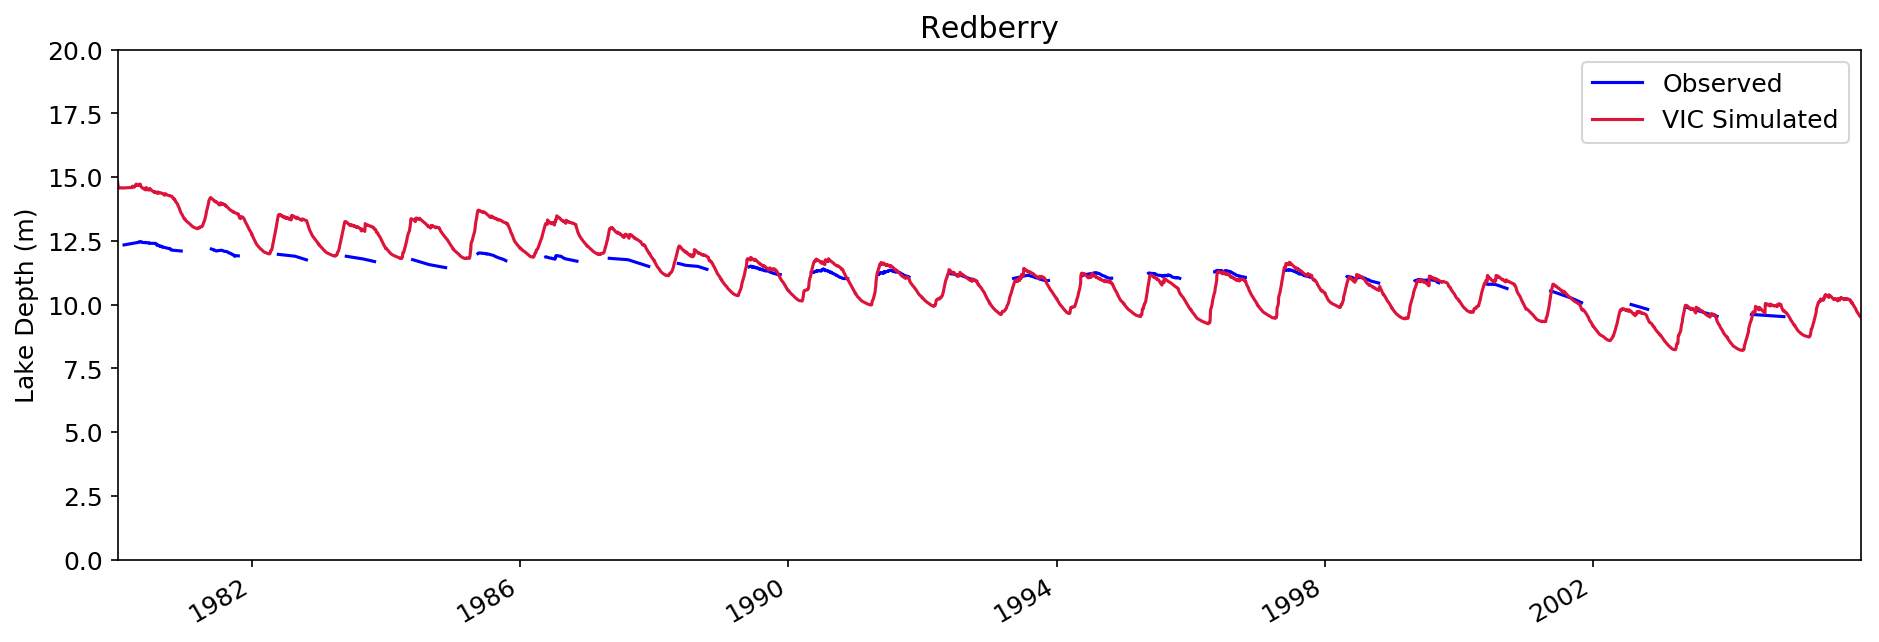

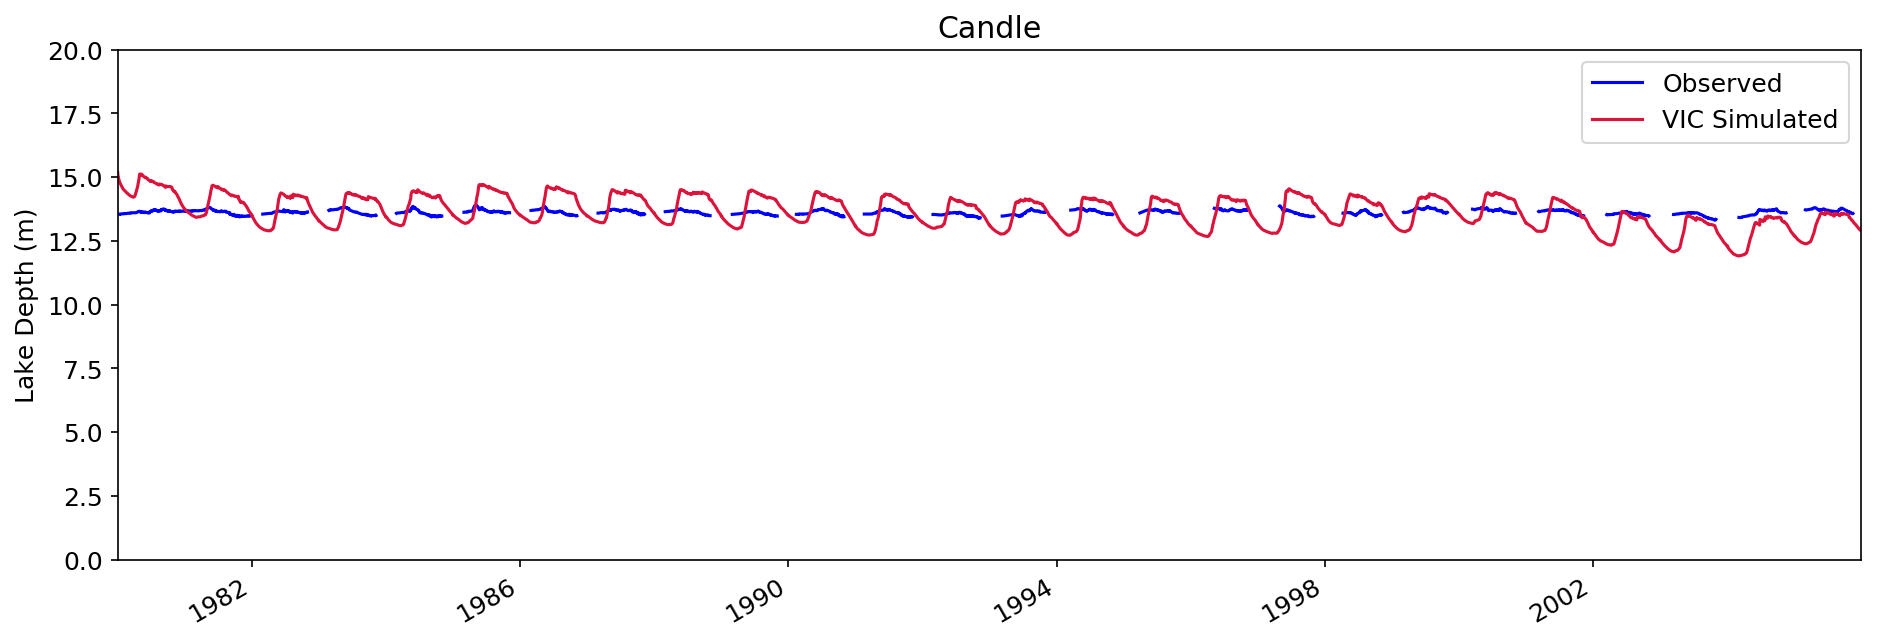

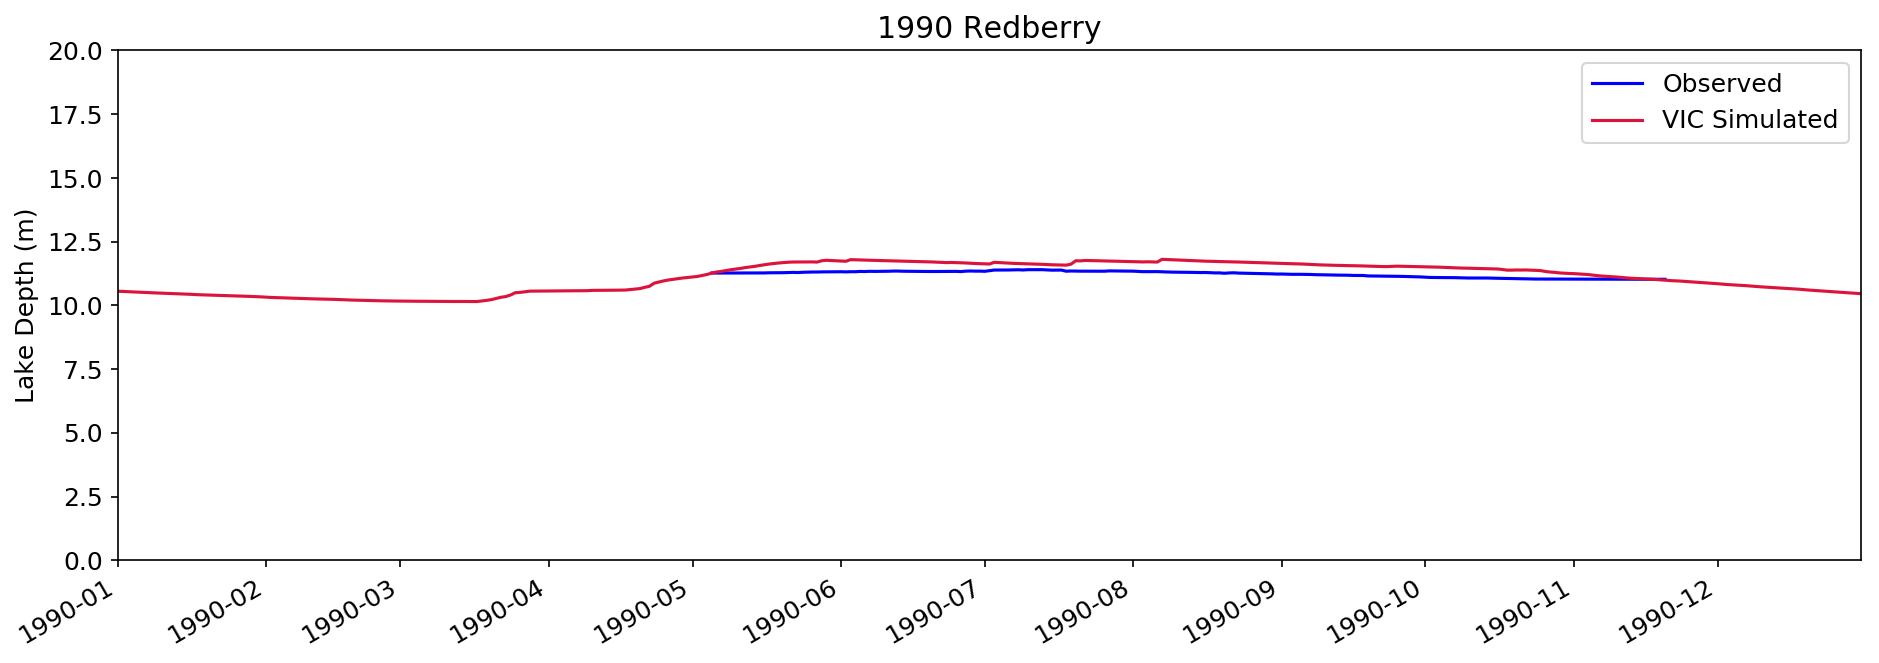

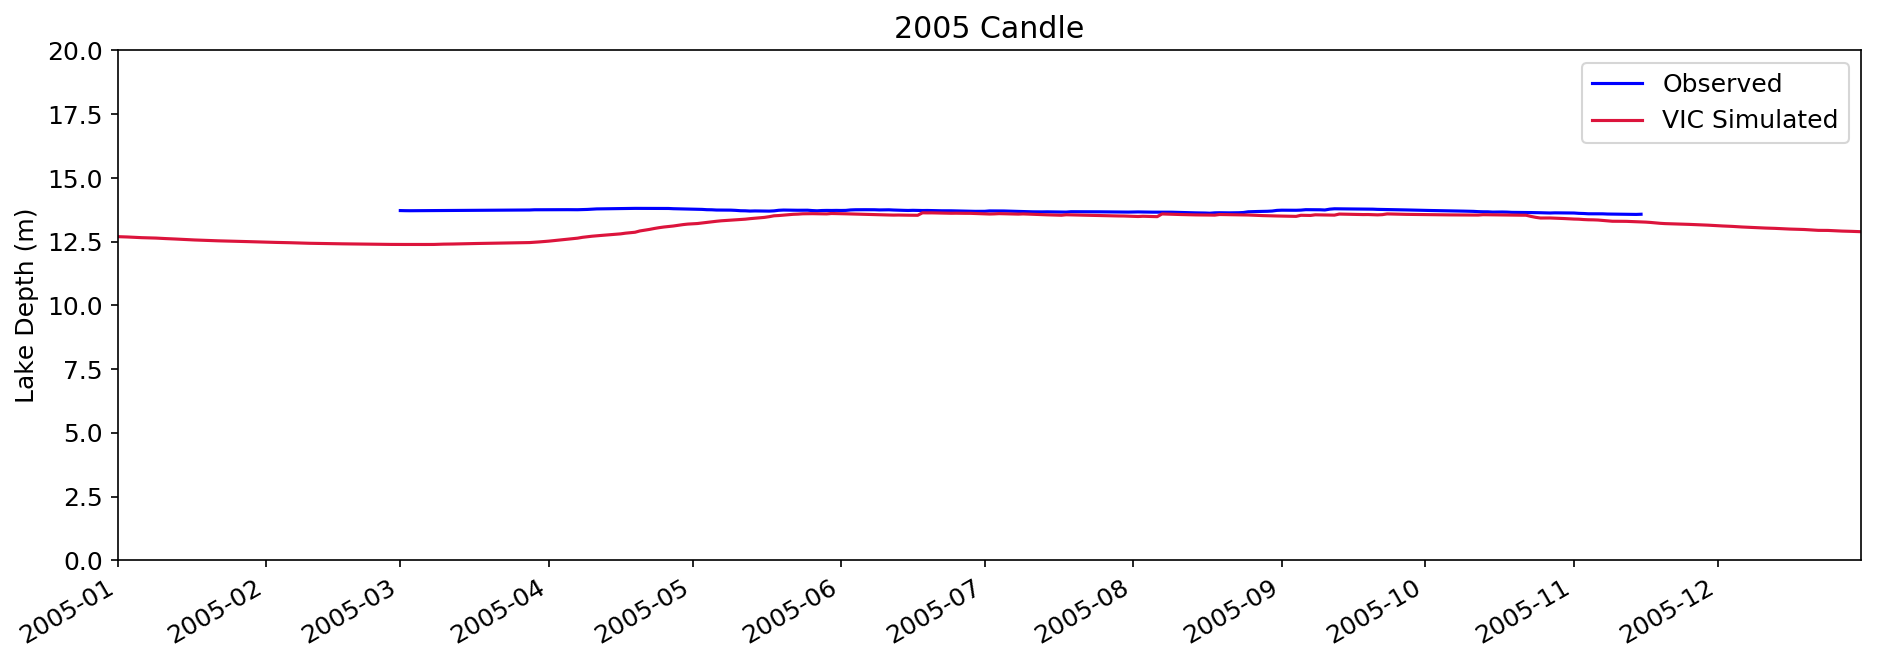

In [182]:
redberry_obs_file = "/home2/svimal/Data/Canada/Redberry_Levels/Daily__Sep-6-2017_01_25_49AM.csv"
candle_obs_file = "/home2/svimal/Data/Canada/Candle_Levels/Daily__Oct-7-2017_01_36_50AM.csv"
redberry_sim_filename = "/home2/svimal/Projects/VIC/Canada/Results/lake_52.625_-107.125"
candle_sim_filename = "/home2/svimal/Projects/VIC/Canada/Results/lake_53.875_-105.375"

def plot_lake(obs_filename, sim_filename, text, i, year = 2000):
    # Redberry Observations
    lake_f = sim_filename
    df_obs = pd.read_csv(obs_filename, sep = "," , skiprows=2)
    df_obs = df_obs.drop(df_obs.columns[[0,1,2,6,8,10,12,14,16,18,20,22,24,26,28]], axis=1)
    df_obs.columns = "year day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")
    df_obs.index = df_obs["year"]
    df_obs["day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")]
    obs = df_obs.set_index('day', append=True).rename_axis('month', 1).stack()
    obs.index = pd.to_datetime(obs.reset_index().iloc[:, :3], errors='coerce')
    obs = obs.loc[obs.index.dropna()]
    
    df_lake = pd.read_csv(lake_f, header=None, delim_whitespace=True,
                          names = ["YEAR","MONTH" ,"DAY" , "ICE_FRACT", "DEPTH", "ICE_HEIGHT" ,"SURF_AREA", "VOLUME"])
    date = str(df_lake['YEAR'][0]) + '-' + str(df_lake['MONTH'][0])+ '-' + str(df_lake['DAY'][0])
    
    obs = obs -  obs.loc['1990-1-1':'2006-12-31'].mean() + df_lake.DEPTH.mean()
    
    # Bias Correction
    #df_lake["DEPTH"] = df_lake.DEPTH + df_lake.DEPTH*(df_lake.DEPTH.mean()/obs.mean())
    
    df_lake.index = pd.date_range(date, periods=len(df_lake), freq="D")
    
    plt.figure(i, dpi=150, figsize=(15,5))
    for y in range(1980, 2006):
        plt.ylim(0,20)
        obs.loc[str(y)+'-1-1':str(y)+'-12-31'].plot(color="b"); df_lake.DEPTH.loc[str(y)+'-1-1':str(y)+'-12-31'].plot(color="crimson")
        plt.legend(["Observed","VIC Simulated"])
    plt.ylabel("Lake Depth (m)");plt.ylim(0,20);plt.title(text);
    #plt.savefig("1980-2006.png")
    
    plt.figure(i+3,dpi=150, figsize=(15,5))
    obs.loc[str(year)+'-1-1':str(year)+'-12-31'].plot(color="b"); df_lake.DEPTH.loc[str(year)+'-1-1':str(year)+'-12-31'].plot(color="crimson")
    plt.legend(["Observed","VIC Simulated"]);plt.ylabel("Lake Depth (m)");plt.ylim(0,20);plt.title(str(year)+" " + text);
    
#run_vic()
plot_lake(redberry_obs_file, redberry_sim_filename, "Redberry", 3, year=1990)
plot_lake(candle_obs_file, candle_sim_filename, "Candle", 4, year=2005)

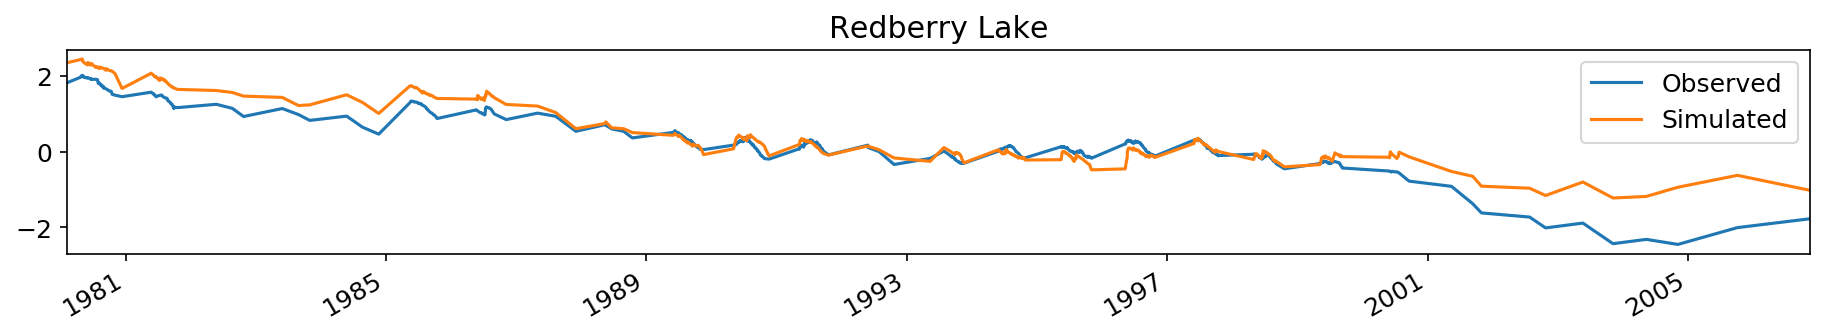

In [183]:
def plot_same_range():
    # Observation
    redberry_obs_filename = "/home2/svimal/Data/Canada/Redberry_Levels/Daily__Sep-6-2017_01_25_49AM.csv"
    df_obs = pd.read_csv(redberry_obs_filename, sep = "," , skiprows=2)
    df_obs = df_obs.drop(df_obs.columns[[0,1,2,6,8,10,12,14,16,18,20,22,24,26,28]], axis=1)
    df_obs.columns = "year day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")
    df_obs.index = df_obs["year"]; df_obs["day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")]
    obs = df_obs.set_index('day', append=True).rename_axis('month', 1).stack()
    obs.index = pd.to_datetime(obs.reset_index().iloc[:, :3], errors='coerce')
    obs = obs.loc[obs.index.dropna()]
    # Simulation
    redberry_sim_filename = "/home2/svimal/Projects/VIC/Canada/Results/lake_52.625_-107.125"
    df_sim = pd.read_csv(redberry_sim_filename, header=None, delim_whitespace=True,
                          names = ["YEAR","MONTH" ,"DAY" , "ICE_FRACT", "DEPTH", "ICE_HEIGHT" ,"SURF_AREA", "VOLUME"])
    date = str(df_sim['YEAR'][0]) + '-' + str(df_sim['MONTH'][0])+ '-' + str(df_sim['DAY'][0])
    df_sim.index = pd.date_range(date, periods=len(df_sim), freq="D")
    # Standardization
    depth = (df_sim.DEPTH - df_sim.DEPTH.mean() )/df_sim.DEPTH.std()
    obs = (obs -  obs.loc['1990-1-1':'2006-12-31'].mean())/obs.std() #+ df_sim.DEPTH.mean()
    # Selecting the right range
    o = obs[df_sim.index].dropna()
    s = depth.where(o!=np.nan).dropna()
    #print o.head(), s.head()
    #print len(o), len(s)
    plt.figure(dpi=150, figsize=(15,2))
    o.plot(); s.plot()
    plt.legend(["Observed", "Simulated"])
    plt.title("Redberry Lake")
    plt.show()
    #print spotpy_setup().objectivefunction(s, o)
plot_same_range()

# Create soil and vegetation parameter files
Grid cell ID is taken from the list of files in the forcing directory

This block takes time to run (like 3 minutes) because its working on a large text file -- 0.25 degree global soil parameter file

In [184]:
def write_soil_file(soil): 
    soil.to_csv("/home2/svimal/Projects/VIC/Canada/VicSetup/Soil_Params", 
                sep=str(' '), columns=None, header=False, index=False, 
                mode='w', line_terminator='\n')

In [185]:
forcing_files = list( set(glob.glob("/home2/svimal/Projects/VIC/Canada/Forcing_Data/*")) - set(glob.glob("/home2/svimal/Projects/VIC/Canada/Forcing_Data/*.jpg")))
soil_param = "/home2/svimal/Projects/VIC/Tian_0.25_global_params/vicinput/global_soil_calib_smoothed_tz"

with open(soil_param, "r") as f:
    data_global = f.readlines()

soil_param_file = []
veg_param_file = []
for f in forcing_files:
    lat = float(f.split("_")[-2])
    lon = float(f.split("_")[-1]) # .strip("-")
    #print lat, lon
    for line_global in data_global:
        lat_global = float(line_global.split()[2])
        lon_global = float(line_global.split()[3]) 
        dist = numpy.sqrt((lon - lon_global)**2 + (lat - lat_global)**2 )    
        if dist < 0.2: # Find the nearest global grid to each local grid
            #print dist, lat, lon
            soil_param_file.append(line_global.split(line_global.split(" ")[2])[0] \
            + str(lat) + " "+ str(lon) + line_global.split(line_global.split(" ")[3])[1][0:-2])
            soil_ID = line_global.split(" ")[1]
            veggies = get_veggies(int(soil_ID))
            no_tiles = str(len(veggies)/2)
            veg_param_file.append(soil_ID+ " " + no_tiles + "\n")
            veg_param_file.extend(veggies)

# Write the veg param file


In [186]:
veg_param = "/home2/svimal/Projects/VIC/Canada/VicSetup/Veg_Params"
with open(veg_param, "w") as f:
    for line in veg_param_file:
        f.write(line)

# Make lake parameter file

In [187]:
#18.540 0.17193 18.430 0.14833 18.240 0.12472 17.894 0.10110 17.179 0.07748 16.540 0.05387 14.905 0.04665 13.270 0.03809 11.635 0.02693
redberry_candle = "172764 0 9 14.55 0.01 15 1\n18.0 0.1644 16.0 0.1444 14.0 0.1203 13.0 0.1102 12.0 0.1010 11.0 0.0910 10.0 0.0850 9.0 0.07515 8.7 0.06509 8.54 0.05193 8.43 0.040 7.894 0.0311 6.54 0.02387 5.905 0.01665 4.27 0.005\n\
177308 0 9 15 0.01 15.3924 1\n18.0 0.2644 16.0 0.2444 14.0 0.2203 13.0 0.2102 12.0 0.2010 11.0 0.1910 10.0 0.1850 9.0 0.17515 8.7 0.16509 8.54 0.15193 8.43 0.140 7.894 0.1311 6.54 0.12387 5.905 0.11665 4.27 0.050\n"
with open("/home2/svimal/Projects/VIC/Canada/VicSetup/Lake_Params_NoSEA", "w") as l:
    l.write(redberry_candle)
    for line in soil_param_file:
        ID = line.split()[1]
        l.write(ID + " -1 9 15 0.01 15.3924 1\n18.0 0.2644 16.0 0.2444 14.0 0.2203 13.0 0.2102 12.0 0.2010 11.0 0.1910 10.0 0.1850 9.0 0.17515 8.7 0.16509 8.54 0.15193 8.43 0.140 7.894 0.1311 6.54 0.12387 5.905 0.11665 4.27 0.050\n")

# Prepare soil parameter file for run
so it's easy to change the parameter values while trying out different VIC runs

In [188]:
line_global.split(line_global.split(" ")[2])[0] \
            + str(lat) + " "+ str(lon) + line_global.split(line_global.split(" ")[3])[1][0:-2]
soil = pd.DataFrame([x.split(" ") for x in soil_param_file])
names  =  "RunNo, GridID, Lat, Lon, Infilt, Ds, DsMax, Ws, c, Exp1, Exp2, Exp3, Ksat1, Ksat2, Ksat3, Phi1, Phi2, Phi3, \
init_moist1, init_moist2, init_moist3, avg_elev, soilD1, soilD2, soilD3, SoilT, SoilTempD, BubP1, BubP2, BubP3, \
BD1, BD2, BD3, QCont1, QCont2, QCont3, SoilDen1, SoilDen2, SoilDen3, GMT, SMCP1, SMCP2, SMCP3, WP1, WP2, WP3, \
SoilRough, SR_Snow, AvgPrecip, ResMois1, ResMois2, ResMois3, FS".split(", ")
soil.columns = names
soil.RunNo = 0
# Put Redberry Lake and Candle Lake on top
Candle_id = list(soil.loc[(soil['Lat'] == "53.875") & soil['Lon'].isin(["-105.375"])].index)[0]
Redberry_id = list(soil.loc[(soil['Lat'] == "52.625") & soil['Lon'].isin(["-107.125"])].index)[0]
soil.loc[0], soil.loc[Redberry_id] = soil.loc[Redberry_id], soil.loc[0]
soil.loc[1], soil.loc[Candle_id] = soil.loc[Candle_id], soil.loc[1]

# Activate only specific grids (Redberry and Candle)

In [189]:
soil.at[0,"RunNo"] = 1 # Run Redberry lake
soil.at[1,"RunNo"] = 0 # Candle lake
soil.head(2)

,RunNo,GridID,Lat,Lon,Infilt,Ds,DsMax,Ws,c,Exp1,Exp2,Exp3,Ksat1,Ksat2,Ksat3,Phi1,Phi2,Phi3,init_moist1,init_moist2,init_moist3,avg_elev,soilD1,soilD2,soilD3,SoilT,SoilTempD,BubP1,BubP2,BubP3,BD1,BD2,BD3,QCont1,QCont2,QCont3,SoilDen1,SoilDen2,SoilDen3,GMT,SMCP1,SMCP2,SMCP3,WP1,WP2,WP3,SoilRough,SR_Snow,AvgPrecip,ResMois1,ResMois2,ResMois3,FS
0,1,172764,52.625,-107.125,0.2552,0.5754,23.0276,0.4332,2.0000,78.3658,78.3658,78.3658,522.2877,573.8089,573.8089,-999,-999,-999,84.3562,618.2278,184.8688,541.4211,0.3000,5.9554,5.5306,0.4627,4.0000,32.8084,33.3855,33.3855,0.3682,0.3145,0.3145,1279.0658,1314.2191,1314.2191,2313.9224,2557.2896,2557.2896,-7.0000,0.6285,0.5995,0.5995,0.3802,0.3781,0.3781,0.0010,0.0005,341.3823,0.0767,0.0844,0.0844,1
1,0,177308,53.875,-105.375,0.1173,0.7581,25.3116,0.5993,2.0000,55.8259,55.8259,55.8259,463.4129,1672.7118,1672.7118,-999,-999,-999,67.9547,434.7312,190.5796,514.5722,0.3000,3.5922,4.4997,-0.6349,4.0000,36.8923,26.3928,26.3928,0.3464,0.3425,0.3425,1251.6874,1309.5581,1309.5581,2251.2029,2755.7004,2755.7004,-7.0000,0.5100,0.5789,0.5789,0.3021,0.3745,0.3745,0.0010,0.0005,445.1511,0.0712,0.0903,0.0903,1



# Calibration

,RunNo,GridID,Lat,Lon,Infilt,Ds,DsMax,Ws,c,Exp1,Exp2,Exp3,Ksat1,Ksat2,Ksat3,Phi1,Phi2,Phi3,init_moist1,init_moist2,init_moist3,avg_elev,soilD1,soilD2,soilD3,SoilT,SoilTempD,BubP1,BubP2,BubP3,BD1,BD2,BD3,QCont1,QCont2,QCont3,SoilDen1,SoilDen2,SoilDen3,GMT,SMCP1,SMCP2,SMCP3,WP1,WP2,WP3,SoilRough,SR_Snow,AvgPrecip,ResMois1,ResMois2,ResMois3,FS
0,1,172764,52.625,-107.125,0.4,0.03,3,0.7,2,78.3658,78.3658,78.3658,522.2877,573.8089,573.8089,-999,-999,-999,60,150,300,541.4211,0.1,0.2,1.5,0.4627,4.0000,32.8084,33.3855,33.3855,0.3682,0.3145,0.3145,1279.0658,1314.2191,1314.2191,2313.9224,2557.2896,2557.2896,-7.0000,0.6285,0.5995,0.5995,0.3802,0.3781,0.3781,0.0010,0.0005,341.3823,0.0767,0.0844,0.0844,0
1,0,177308,53.875,-105.375,0.4,0.03,3,0.7,2,55.8259,55.8259,55.8259,463.4129,1672.7118,1672.7118,-999,-999,-999,60,150,300,514.5722,0.1,0.2,1.5,-0.6349,4.0000,36.8923,26.3928,26.3928,0.3464,0.3425,0.3425,1251.6874,1309.5581,1309.5581,2251.2029,2755.7004,2755.7004,-7.0000,0.5100,0.5789,0.5789,0.3021,0.3745,0.3745,0.0010,0.0005,445.1511,0.0712,0.0903,0.0903,0


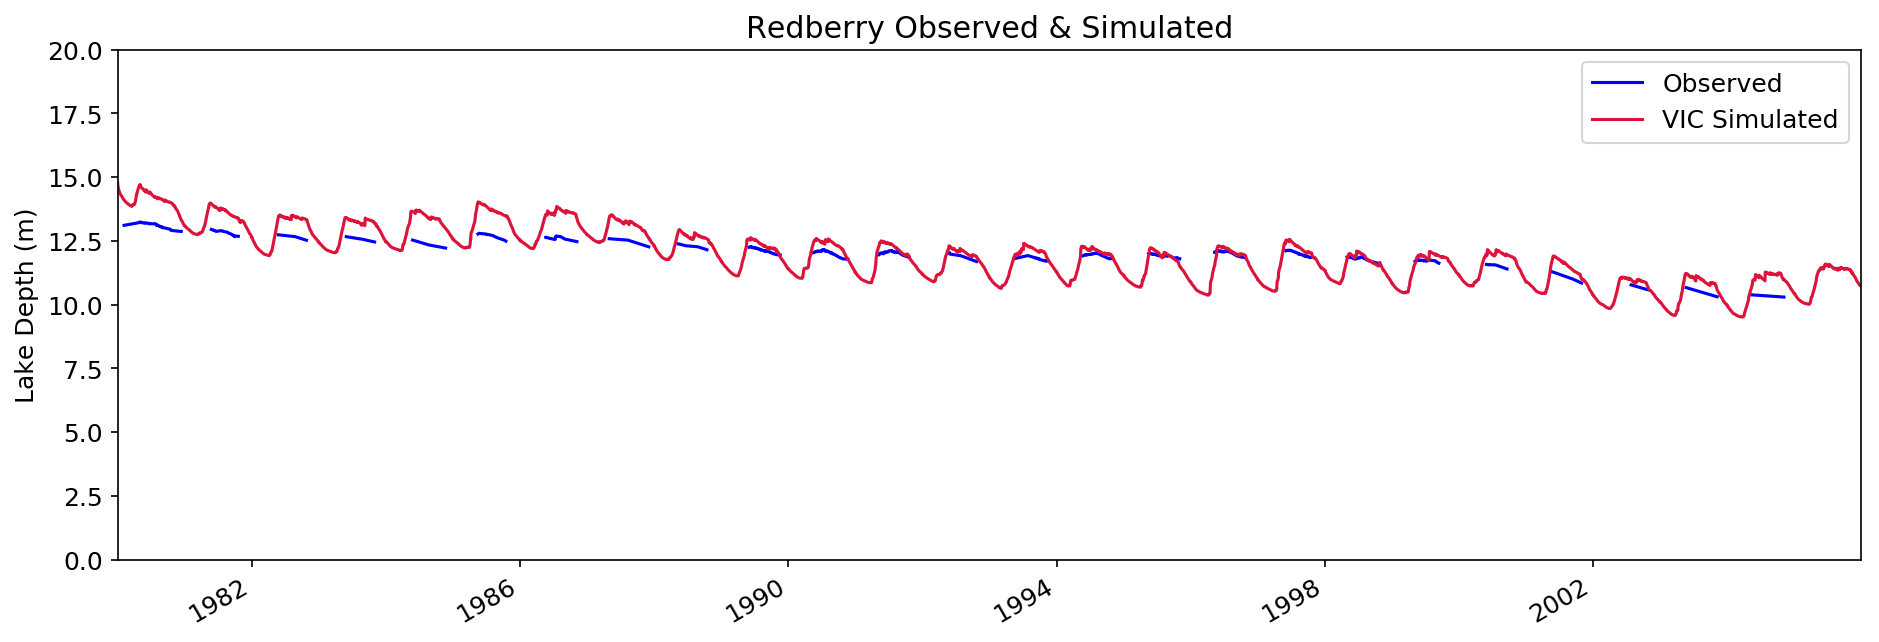

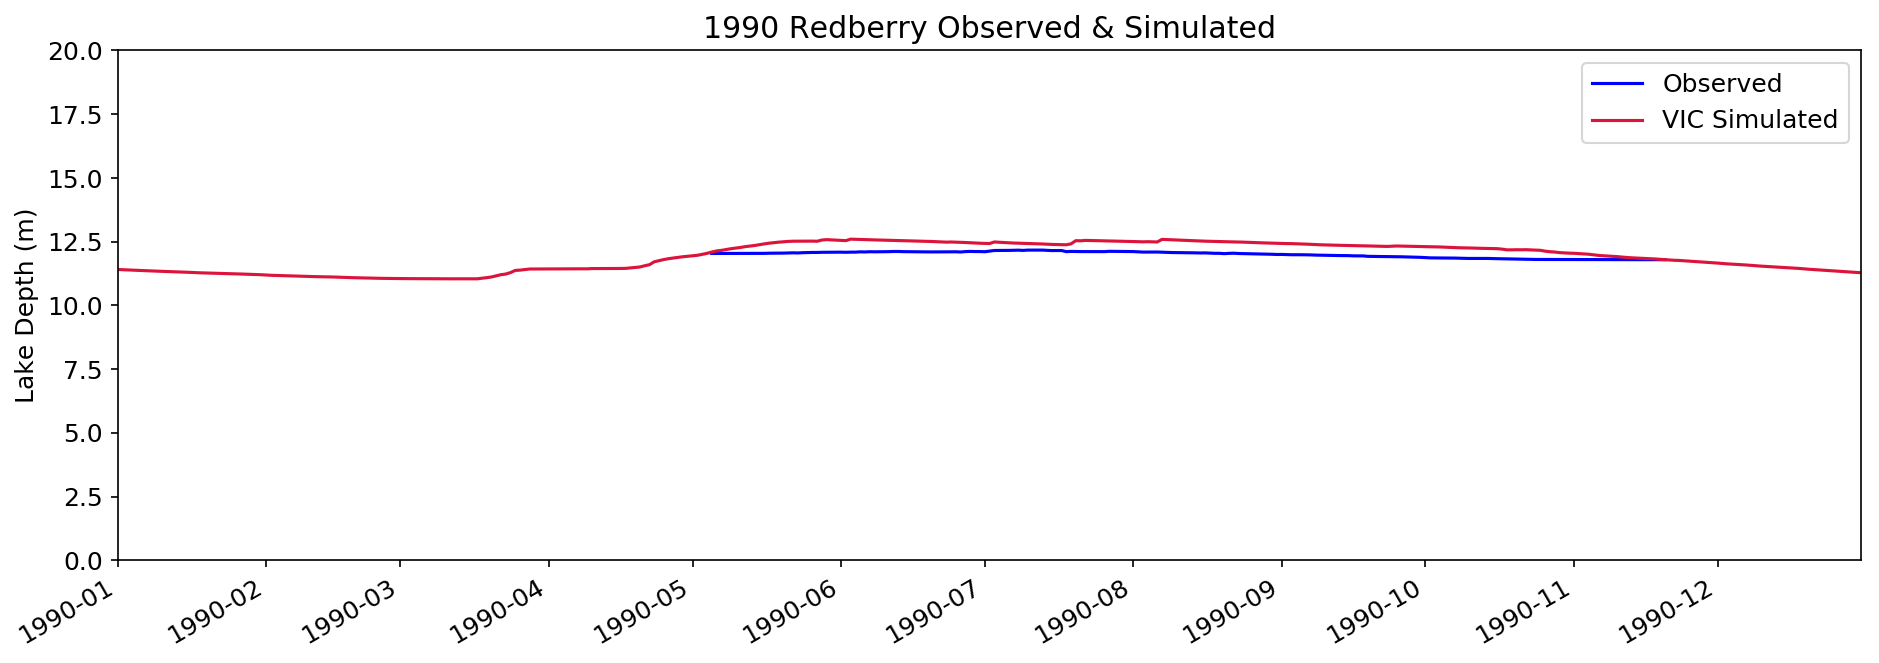

In [190]:
soil.DsMax = 3
soil.Infilt = 0.40
soil.Ds = 0.03
soil.Ws = 0.70
soil.c = 2
soil.soilD1 = 0.1
soil.soilD2 = 0.2
soil.soilD3 = 1.5
soil.init_moist1 = 60
soil.init_moist2 = 150
soil.init_moist3 = 300
soil.FS = 0
write_soil_file(soil)
run_vic()
plot_lake(redberry_obs_file, redberry_sim_filename, "Redberry Observed & Simulated", 3, year=1990)
#plot_lake(candle_obs_file, candle_sim_filename, "Candle Observed & Simulated", 4, year=1990)
soil.head(2)

# Plot Fluxes and SWE

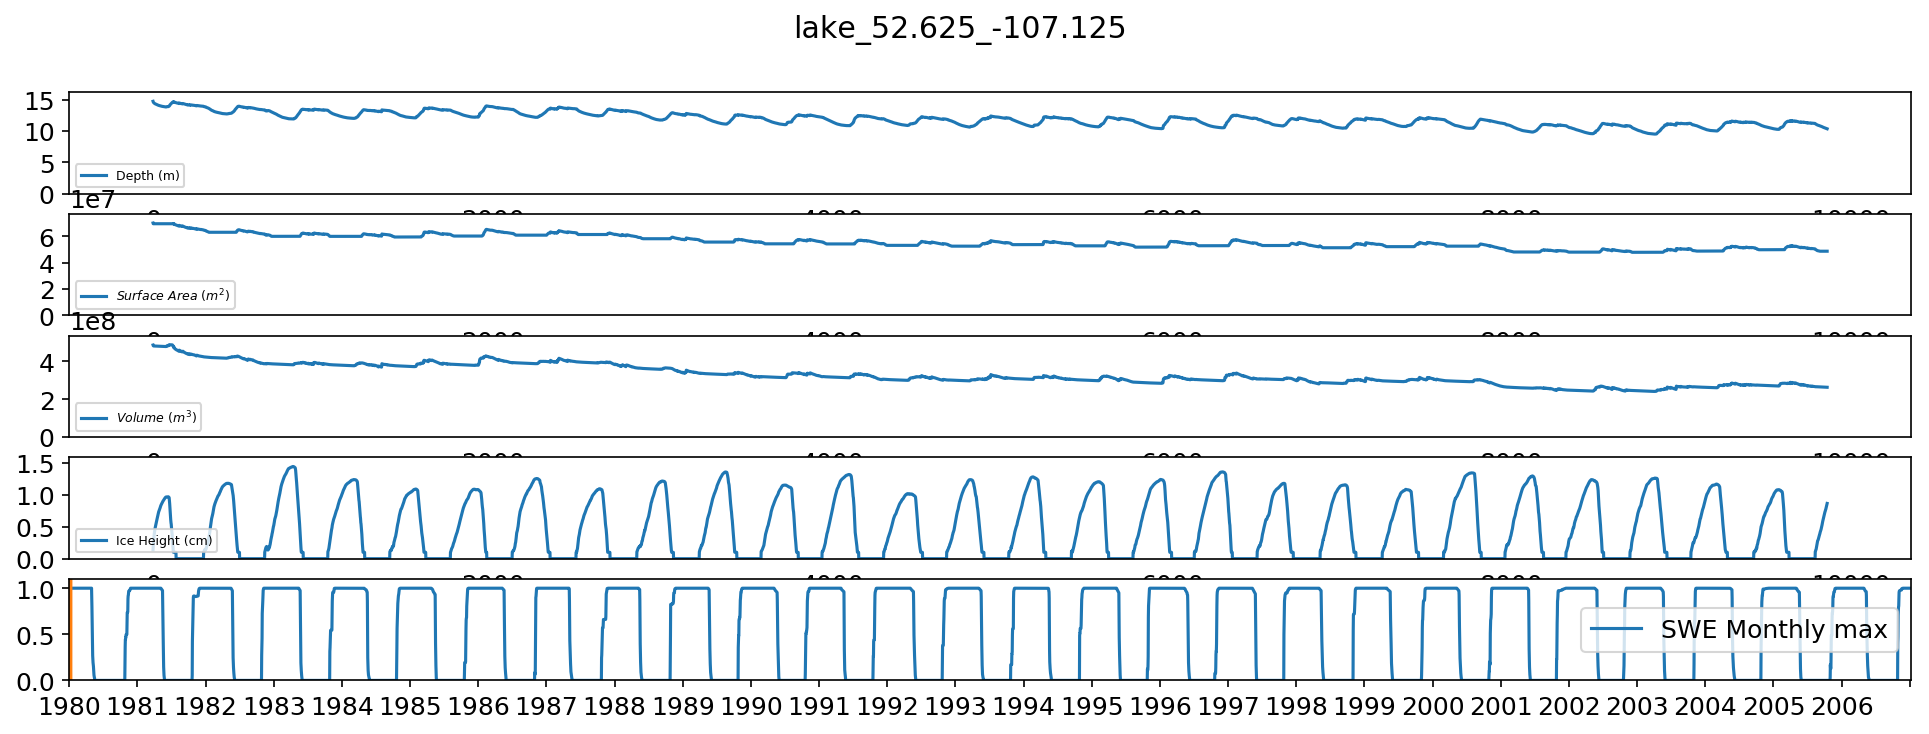

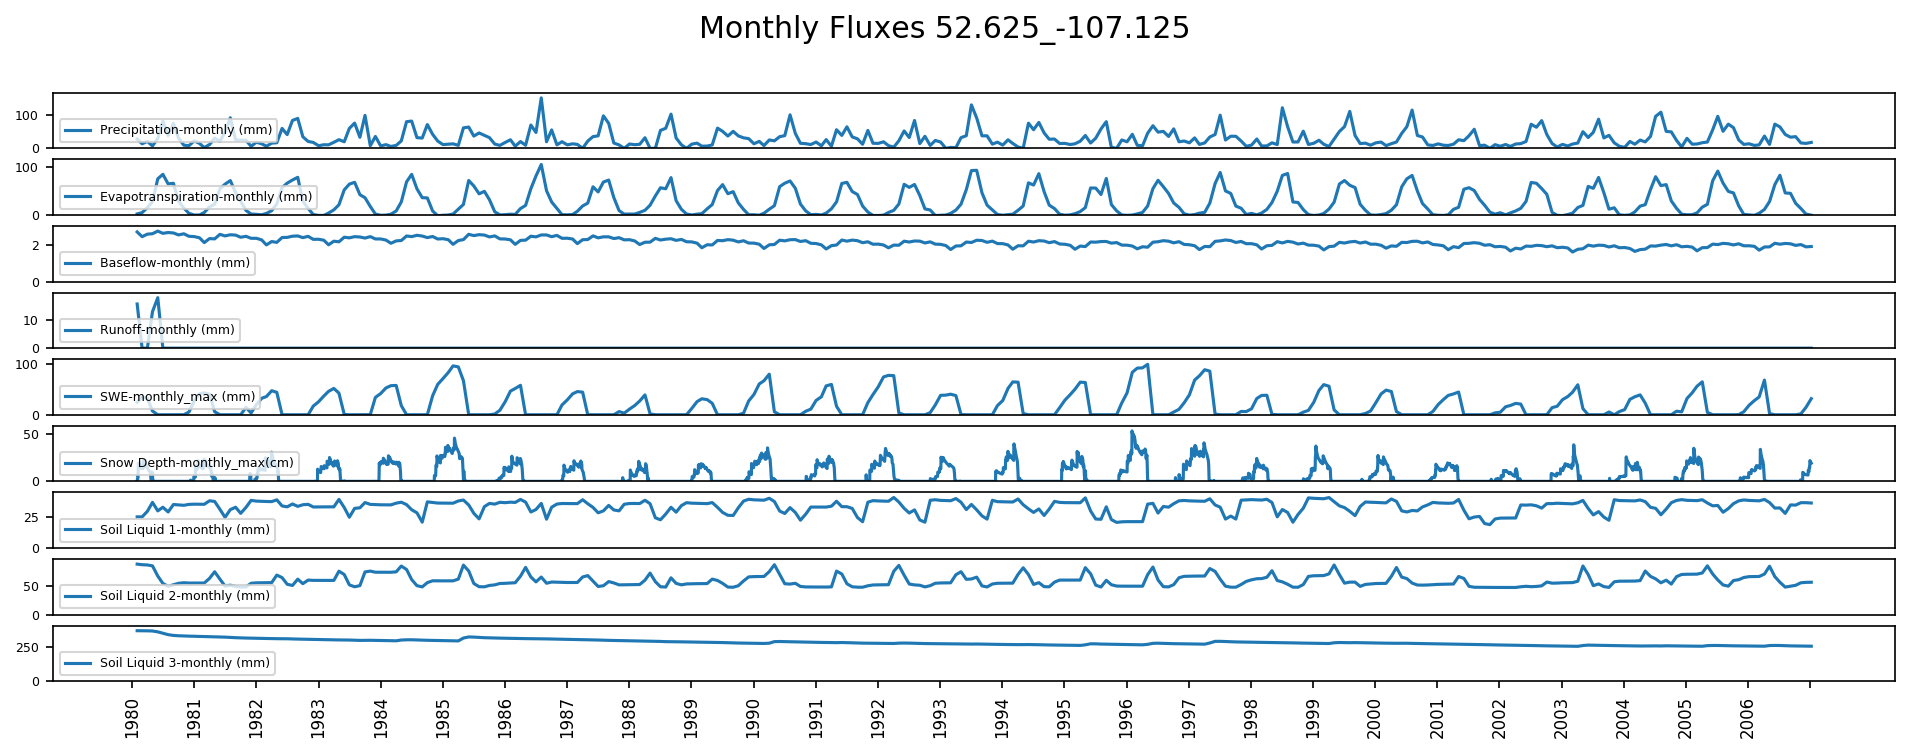

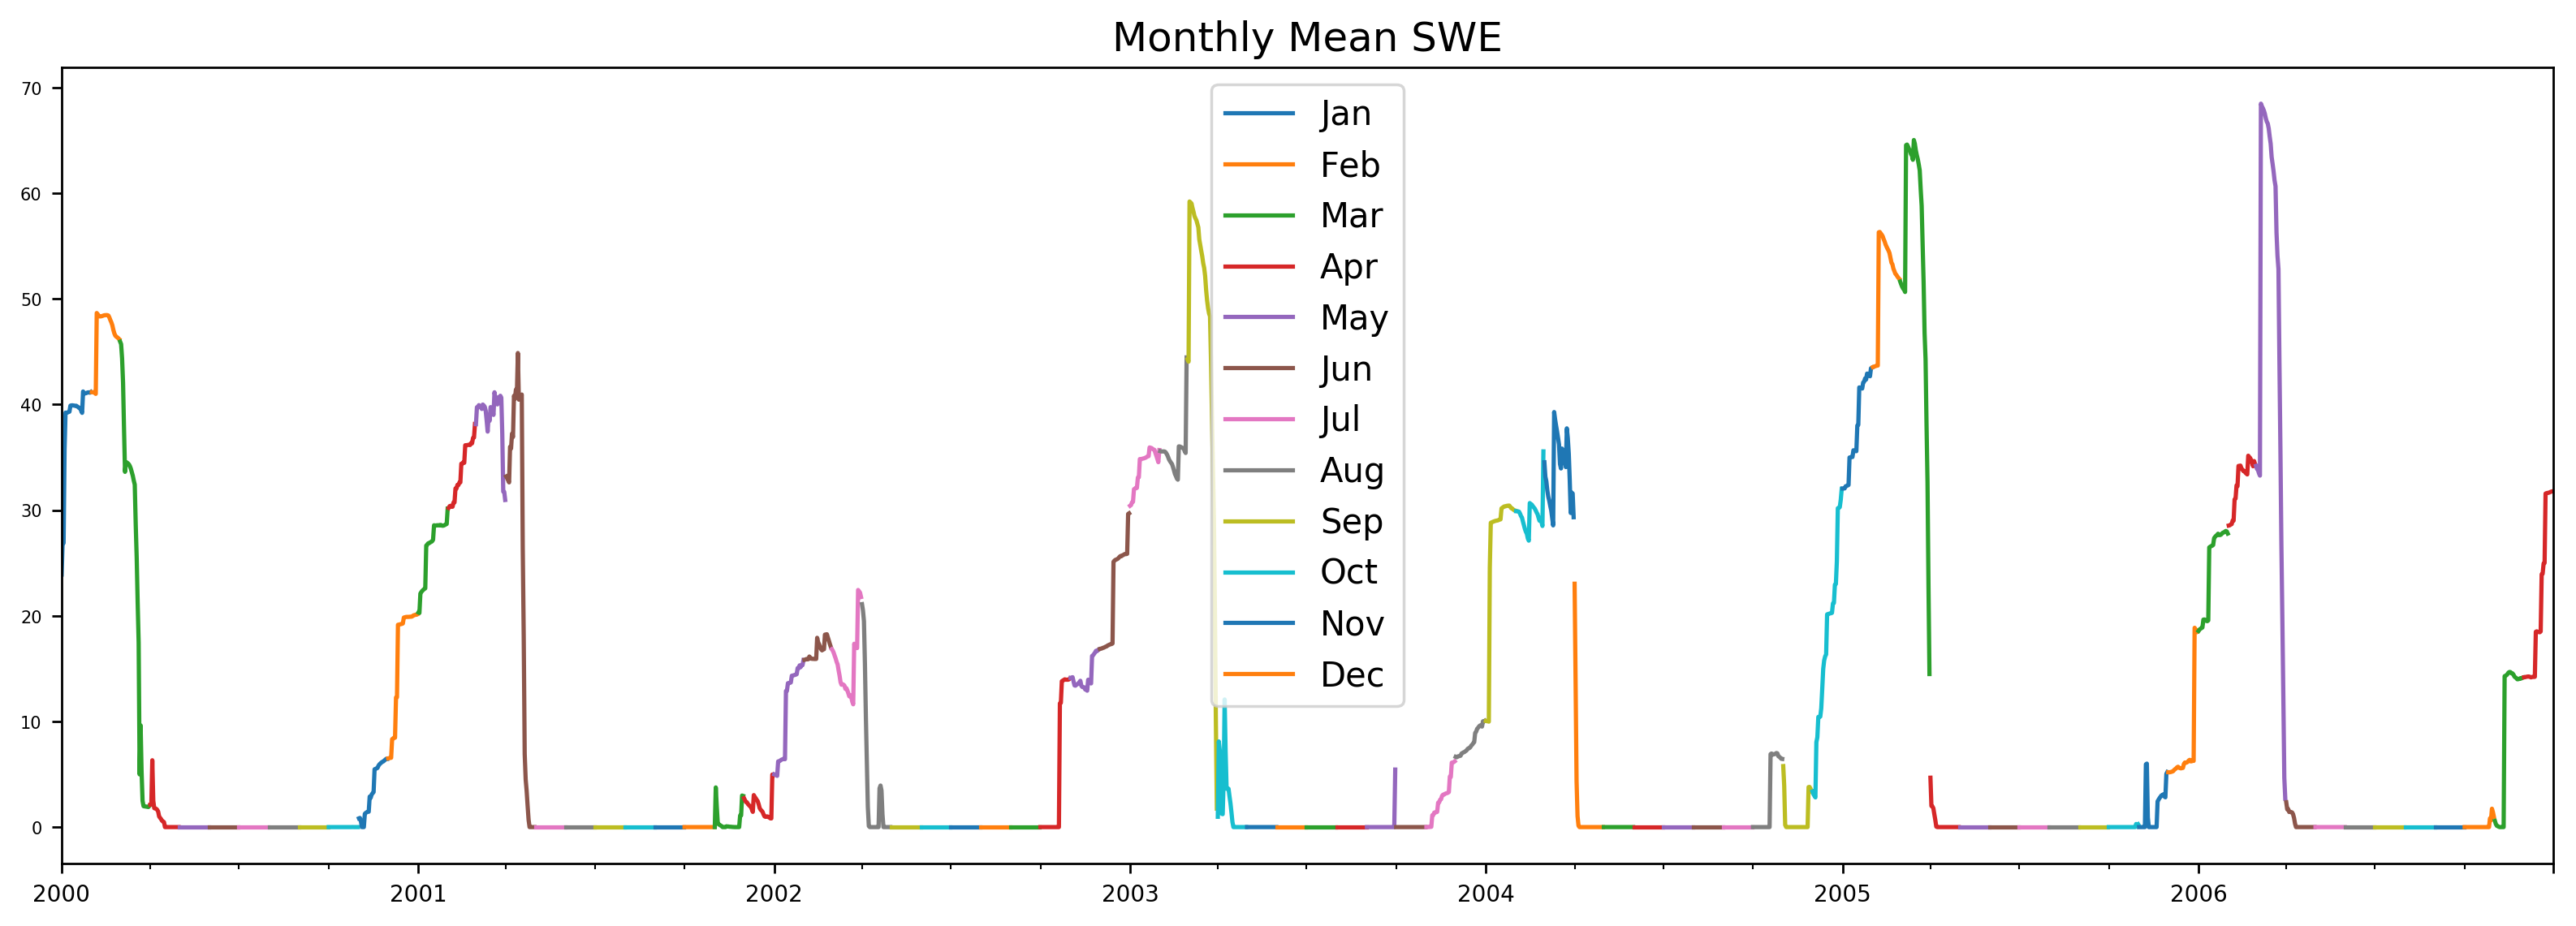

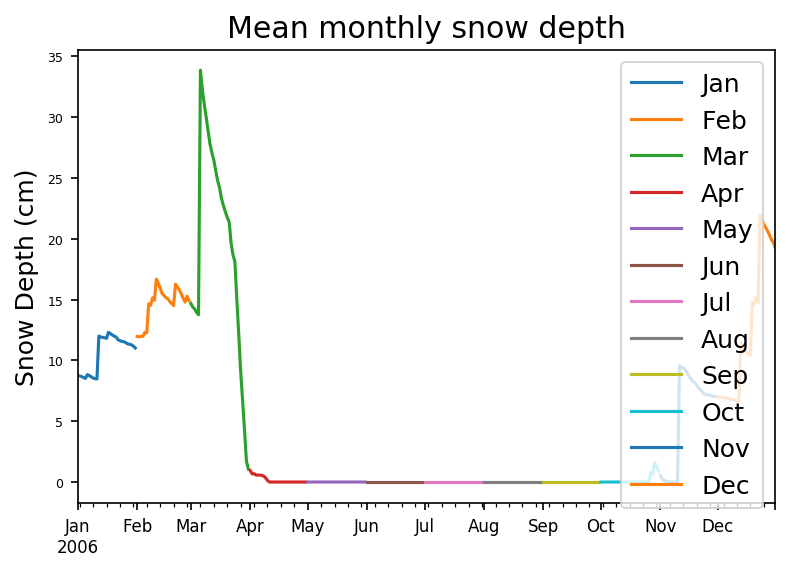

In [191]:
Redberry = [52.625, -107.125]
sys.path.insert(0, '/home2/svimal/Projects/VIC/Canada/') # or: sys.path.insert(0, os.getcwd())
os.chdir("/home2/svimal/Projects/VIC/Canada/Results")
plot.plot_lake_snow("Redberry","fluxes_"+str(Redberry[0])+"_"+str(Redberry[1]), 
                               "snow_"+str(Redberry[0])+"_"+str(Redberry[1]), 
                               "lake_"+str(Redberry[0])+"_"+str(Redberry[1]))

# Calibration

In [196]:
class vic_model(object):
    def __init__(self,startTime,endTime):
        self.st = startTime
        self.et = endTime
        return
        
    def get_obs(self):
        #obsSeries = [5.5,5.5,5.5,5.5,5.5]
        #self.observations = obsSeries
        # Observation
        redberry_obs_filename = "/home2/svimal/Data/Canada/Redberry_Levels/Daily__Sep-6-2017_01_25_49AM.csv"
        df_obs = pd.read_csv(redberry_obs_filename, sep = "," , skiprows=2)
        df_obs = df_obs.drop(df_obs.columns[[0,1,2,6,8,10,12,14,16,18,20,22,24,26,28]], axis=1)
        df_obs.columns = "year day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")
        df_obs.index = df_obs["year"]; df_obs["day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")]
        obs = df_obs.set_index('day', append=True).rename_axis('month', 1).stack()
        obs.index = pd.to_datetime(obs.reset_index().iloc[:, :3], errors='coerce')
        obs = obs.loc[obs.index.dropna()]

        # Simulation
        redberry_sim_filename = "/home2/svimal/Projects/VIC/Canada/Results/lake_52.625_-107.125"
        df_sim = pd.read_csv(redberry_sim_filename, header=None, delim_whitespace=True,
                              names = ["YEAR","MONTH" ,"DAY" , "ICE_FRACT", "DEPTH", "ICE_HEIGHT" ,"SURF_AREA", "VOLUME"])
        date = str(df_sim['YEAR'][0]) + '-' + str(df_sim['MONTH'][0])+ '-' + str(df_sim['DAY'][0])
        df_sim.index = pd.date_range(date, periods=len(df_sim), freq="D")

        # Standardization
        depth = (df_sim.DEPTH - df_sim.DEPTH.mean() )/df_sim.DEPTH.std()
        obs = (obs -  obs.loc['1990-1-1':'2006-12-31'].mean())/obs.std() #+ df_sim.DEPTH.mean()

        # Selecting the right range
        o = obs[df_sim.index].dropna()
        s = depth.where(o!=np.nan).dropna()
        self.observations = list(o)
        #print type(list(o)), list(o)[0]        
        #print len(s), len(o)
        return

    def run_vic(self, binfilt=None,Ws=None,DsMax=None,Ds=None,soil_d2=None,soil_d3=None):
        #simSeries = [binfilt+Ws+Ds+soil_d2+soil_d3 for x in range(5)]
        soil.DsMax = DsMax
        soil.Infilt = binfilt
        soil.Ds = Ds
        soil.Ws = Ws
        soil.c = 2
        soil.soilD1 = 0.1
        soil.soilD2 = soil_d2
        soil.soilD3 = soil_d3      
        write_soil_file(soil)
        run_vic()
        # Observation
        redberry_obs_filename = "/home2/svimal/Data/Canada/Redberry_Levels/Daily__Sep-6-2017_01_25_49AM.csv"
        df_obs = pd.read_csv(redberry_obs_filename, sep = "," , skiprows=2)
        df_obs = df_obs.drop(df_obs.columns[[0,1,2,6,8,10,12,14,16,18,20,22,24,26,28]], axis=1)
        df_obs.columns = "year day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")
        df_obs.index = df_obs["year"]; df_obs["day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")]
        obs = df_obs.set_index('day', append=True).rename_axis('month', 1).stack()
        obs.index = pd.to_datetime(obs.reset_index().iloc[:, :3], errors='coerce')
        obs = obs.loc[obs.index.dropna()]

        # Simulation
        redberry_sim_filename = "/home2/svimal/Projects/VIC/Canada/Results/lake_52.625_-107.125"
        df_sim = pd.read_csv(redberry_sim_filename, header=None, delim_whitespace=True,
                              names = ["YEAR","MONTH" ,"DAY" , "ICE_FRACT", "DEPTH", "ICE_HEIGHT" ,"SURF_AREA", "VOLUME"])
        date = str(df_sim['YEAR'][0]) + '-' + str(df_sim['MONTH'][0])+ '-' + str(df_sim['DAY'][0])
        df_sim.index = pd.date_range(date, periods=len(df_sim), freq="D")

        # Standardization
        depth = (df_sim.DEPTH - df_sim.DEPTH.mean() )/df_sim.DEPTH.std()
        obs = (obs -  obs.loc['1990-1-1':'2006-12-31'].mean())/obs.std() #+ df_sim.DEPTH.mean()

        # Selecting the right range
        o = obs[df_sim.index].dropna()
        s = depth.where(o!=np.nan).dropna()
        simSeries = list(s)
        #print len(s), len(o)
        plot_same_range()
        return simSeries
    
class spotpy_setup(object):
    def __init__(self):
        self.datastart     = datetime.date(1980,1,1) # calibration start
        self.dataend       = datetime.date(2006,12,31) # calibration end
        self.vicmodel = vic_model(self.datastart,self.dataend) # routine to run model
        # model parameters to calibrate
        self.params = [spotpy.parameter.Uniform('binfil',0.01,0.5),
                       spotpy.parameter.Uniform('Ws',0.01,1.),
                       spotpy.parameter.Uniform('DsMax',0.01,15.),
                       spotpy.parameter.Uniform('Ds',0.01,1.),
                       spotpy.parameter.Uniform('Soil D2',0.1,1.5),
                       spotpy.parameter.Uniform('Soil D3',0.3,2)
                       ]
        self.soil = soil
        return
                       
    def parameters(self):
        return spotpy.parameter.generate(self.params)

    def simulation(self,vector):
        simulations= self.vicmodel.run_vic(binfilt=vector[0],Ws=vector[1],DsMax=vector[2],Ds=vector[3],soil_d2=vector[4],soil_d3=vector[5])
        return simulations
    
    def evaluation(self,evaldates=False):
        self.vicmodel.get_obs()
        return self.vicmodel.observations

    def objectivefunction(self,simulation,evaluation):
        l = len(evaluation)
        objectivefunction= -spotpy.objectivefunctions.rmse(evaluation[l/2:],simulation[l/2:])
        #print "Start", self.datastart, "End", self.dataend
        return objectivefunction

loaded!


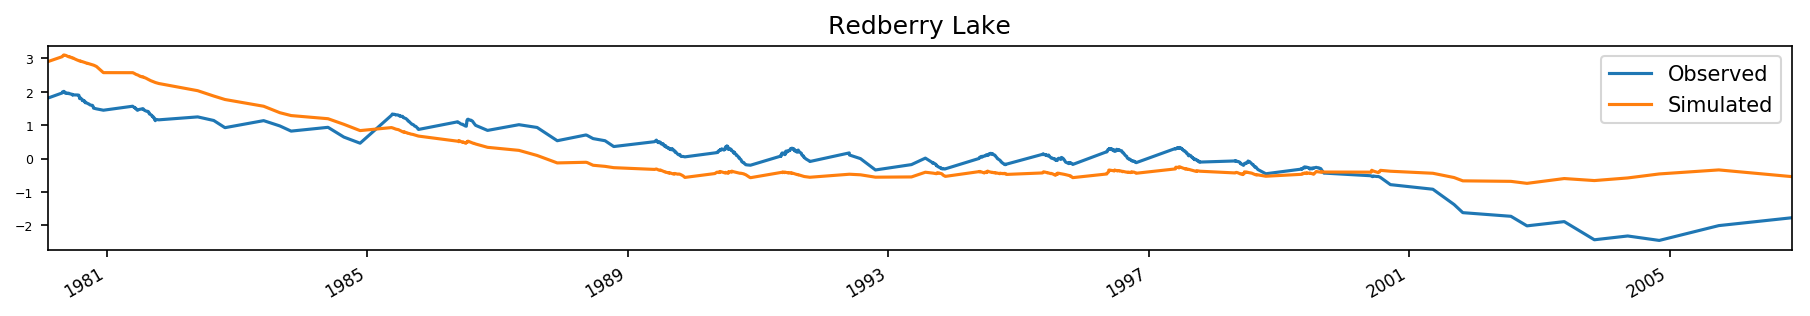

Initialize database...
0 of 1000 (best like=-0.638451)


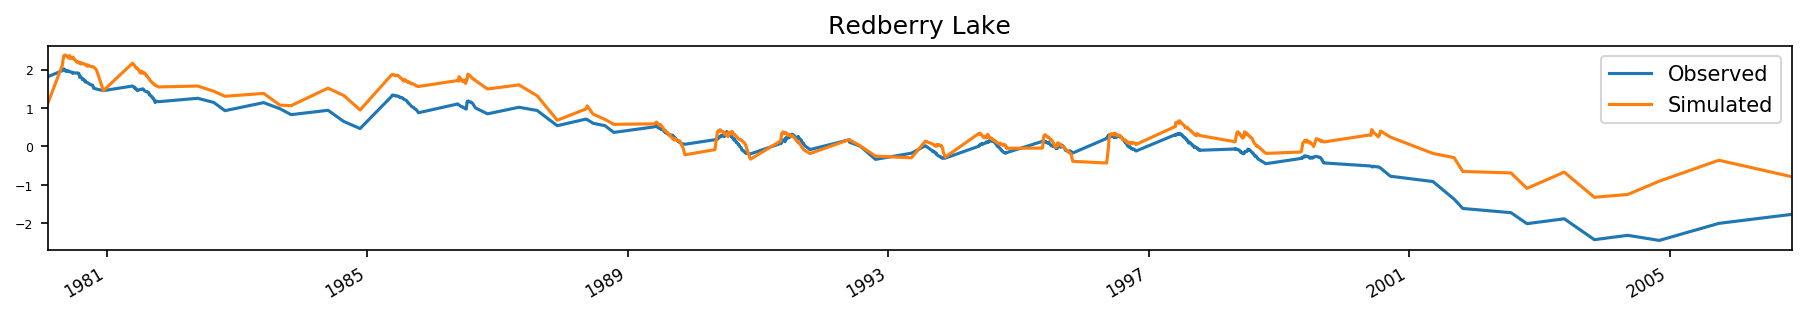

1 of 1000 (best like=-0.354106)


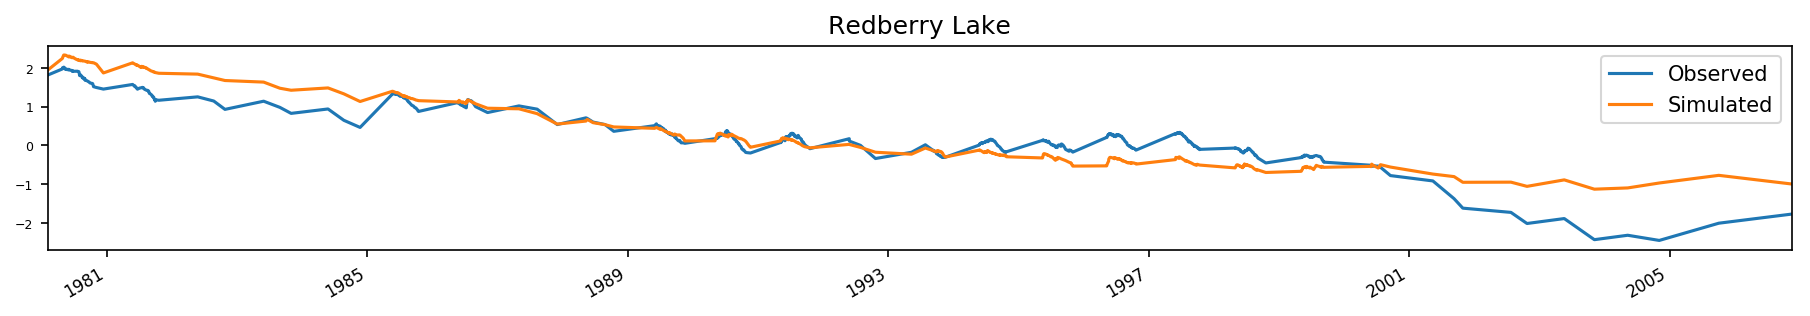

2 of 1000 (best like=-0.354106)


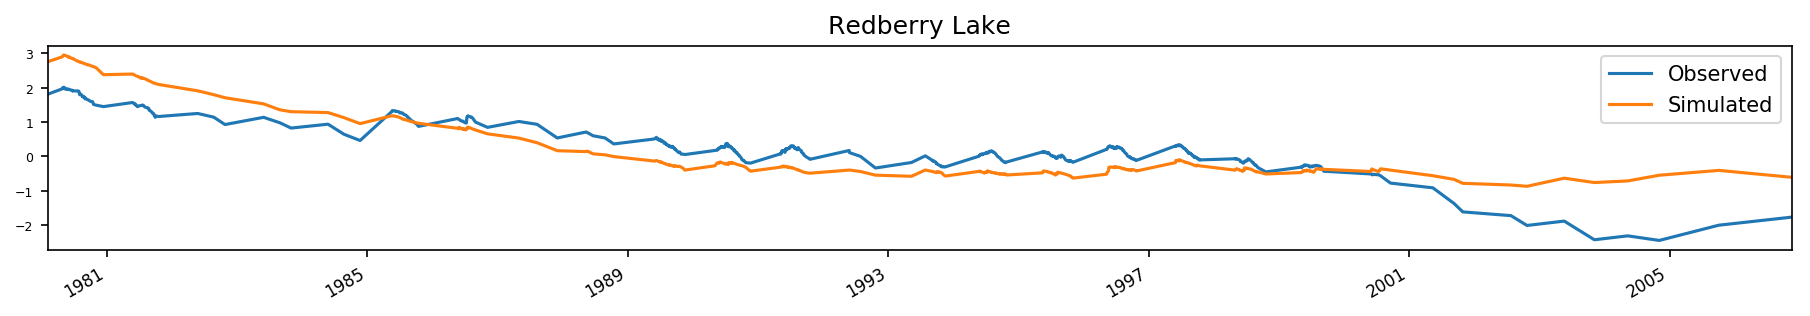

3 of 1000 (best like=-0.354106)


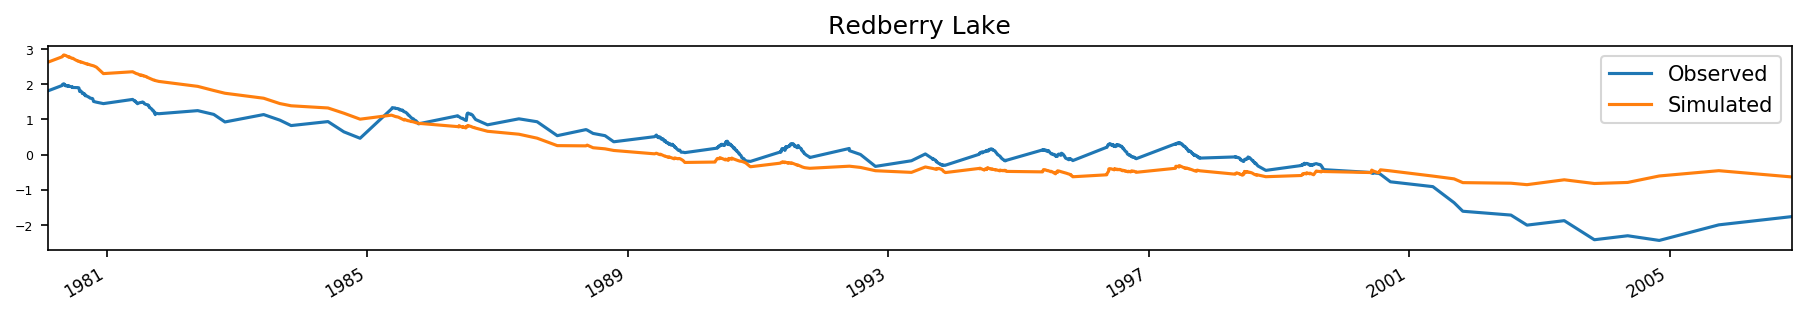

4 of 1000 (best like=-0.354106)


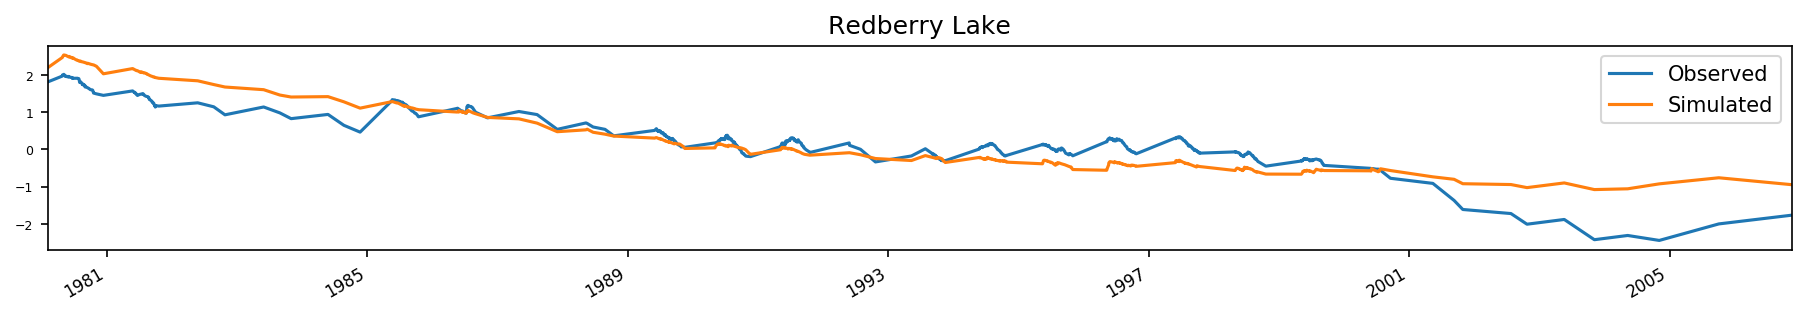

5 of 1000 (best like=-0.354106)


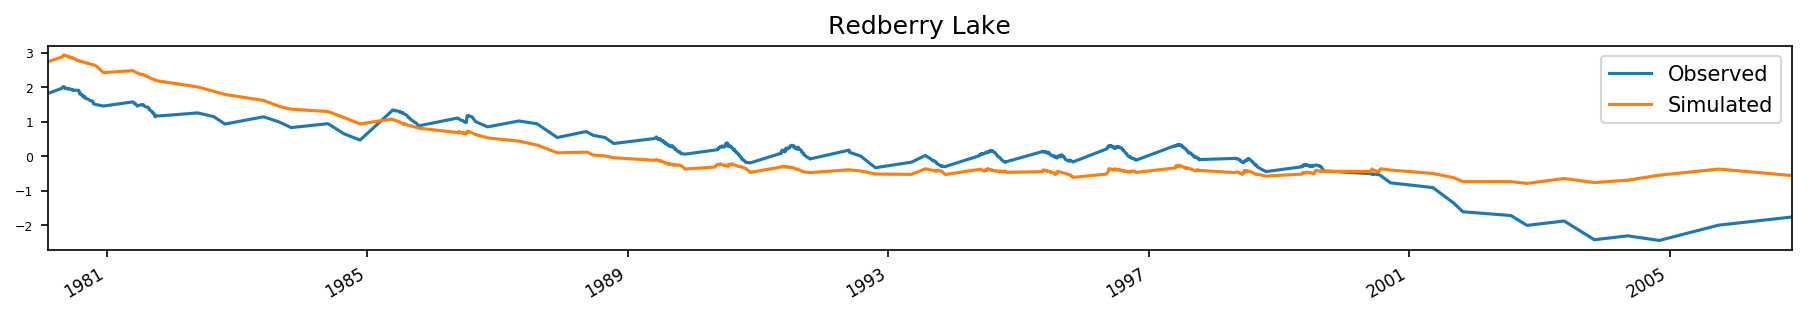

6 of 1000 (best like=-0.354106)


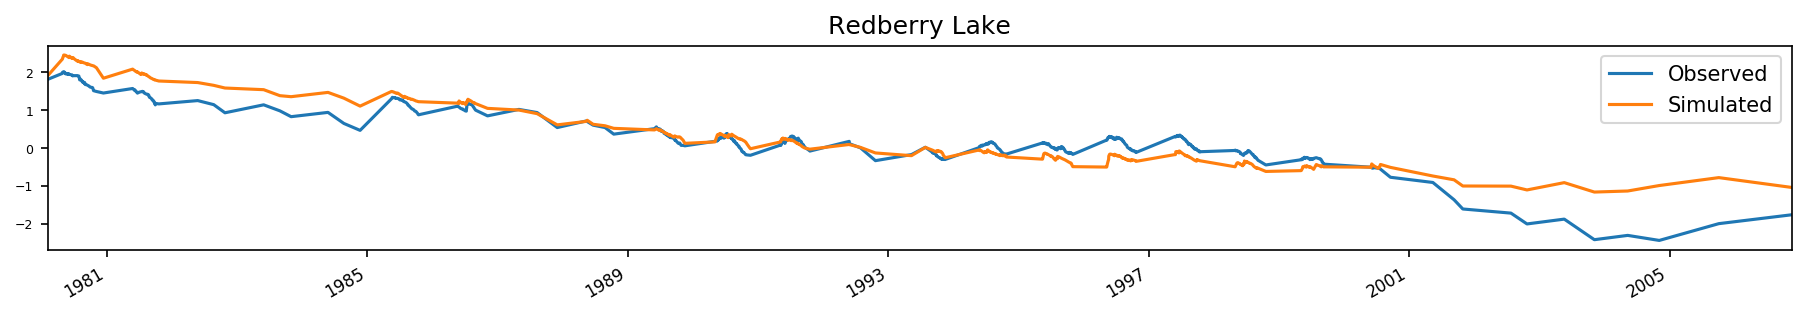

7 of 1000 (best like=-0.310153)


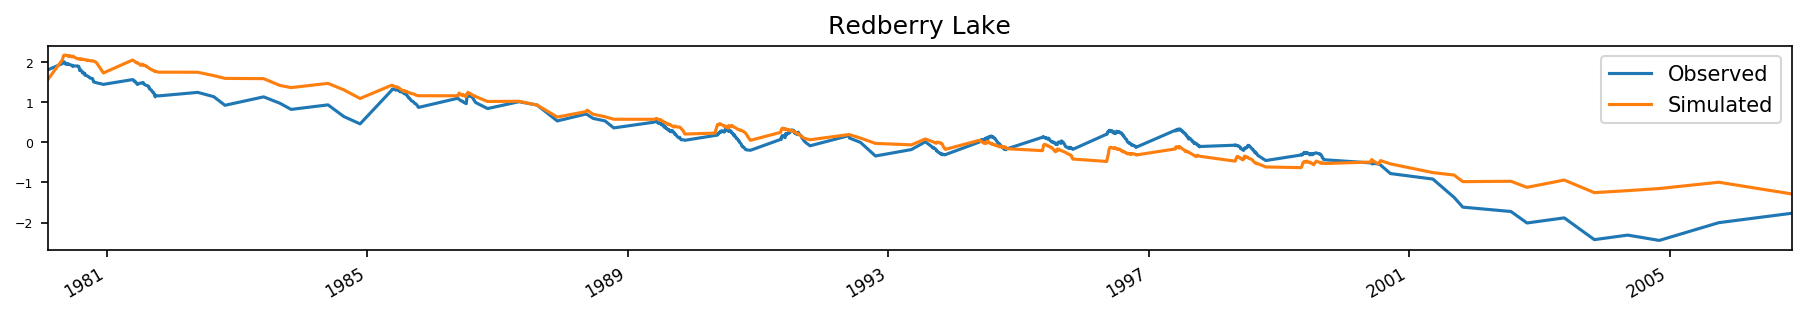

8 of 1000 (best like=-0.274055)


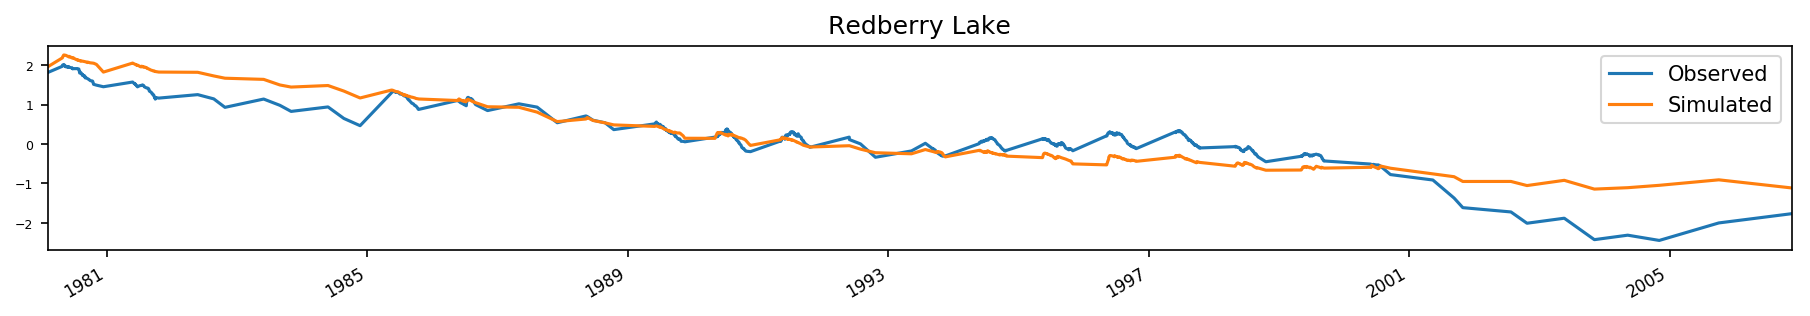

9 of 1000 (best like=-0.274055)


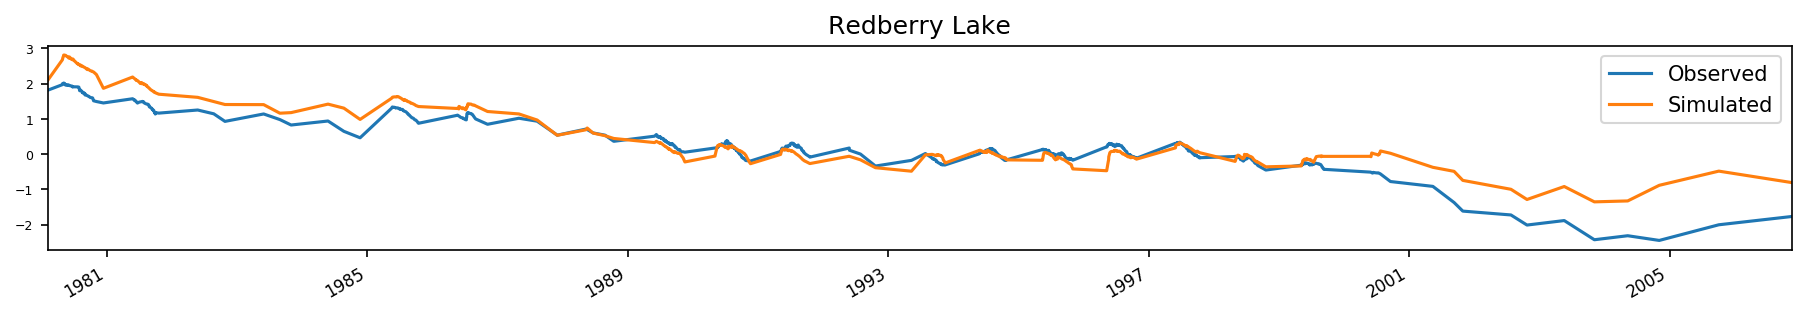

10 of 1000 (best like=-0.274055)


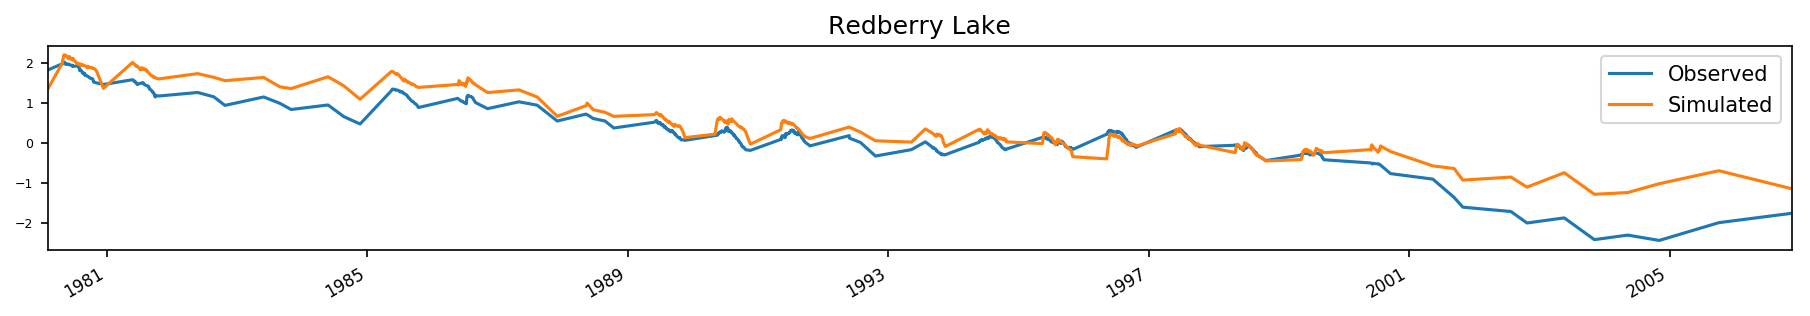

11 of 1000 (best like=-0.26306)


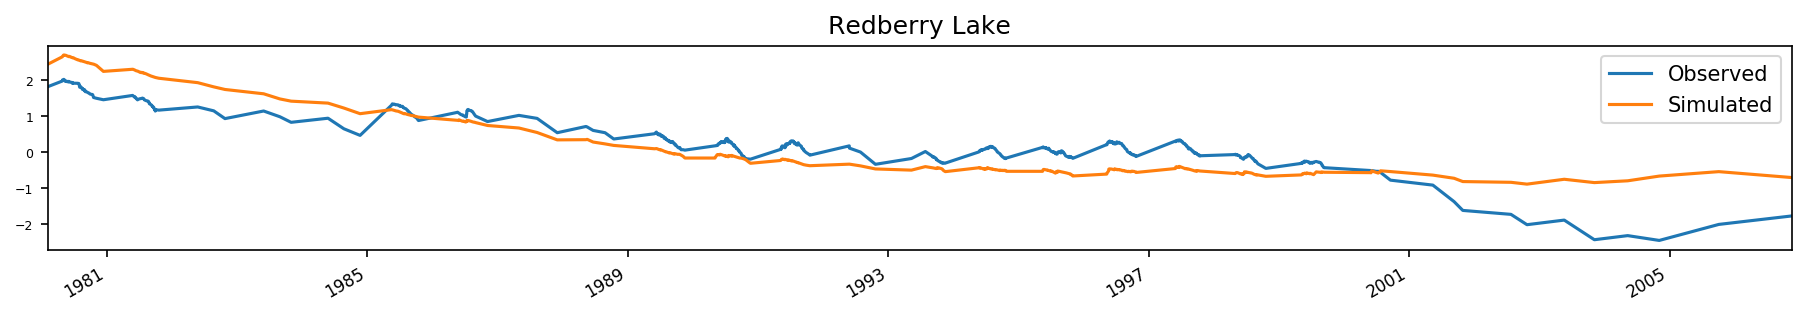

12 of 1000 (best like=-0.26306)


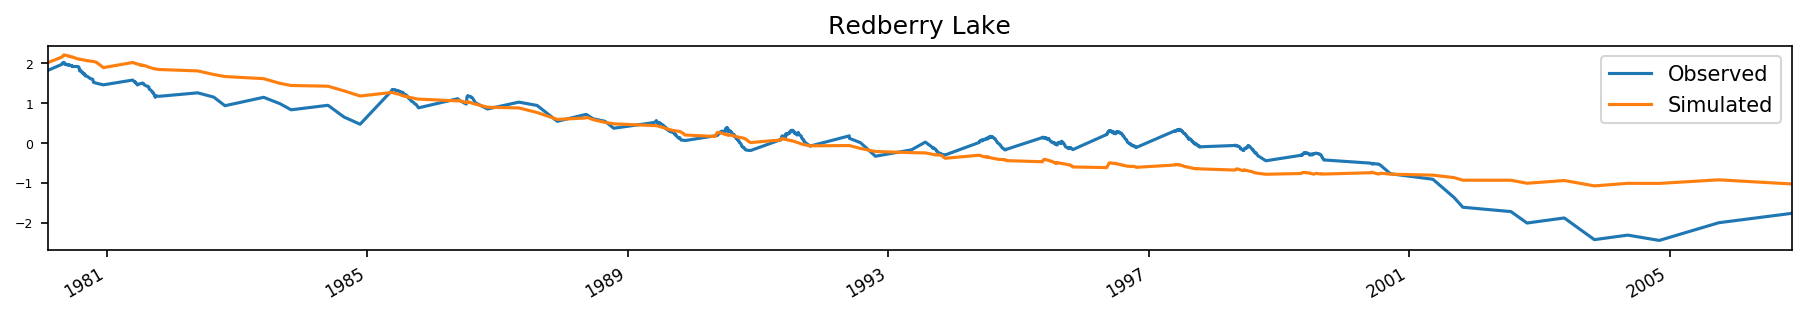

13 of 1000 (best like=-0.26306)


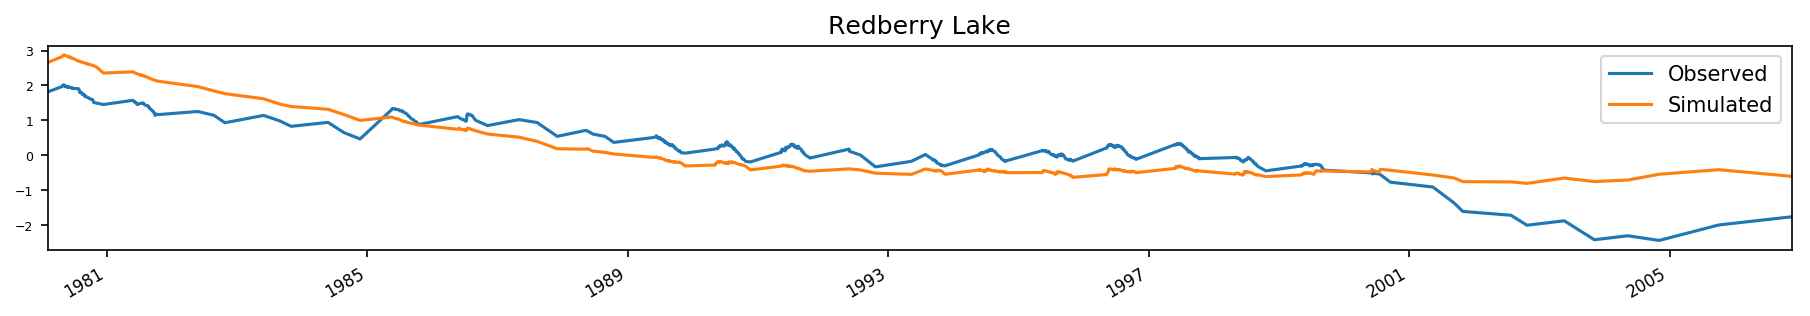

14 of 1000 (best like=-0.26306)


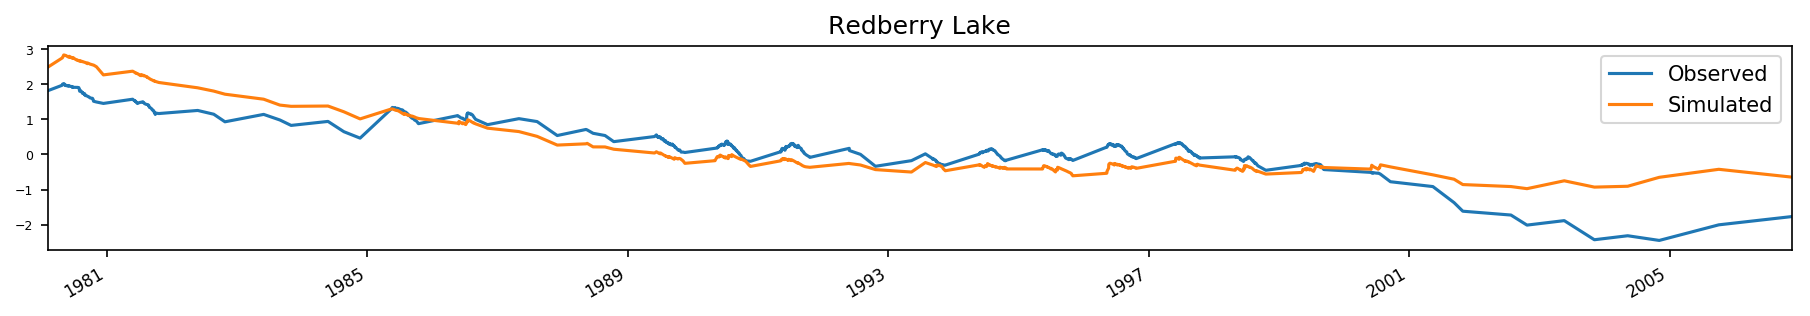

15 of 1000 (best like=-0.26306)


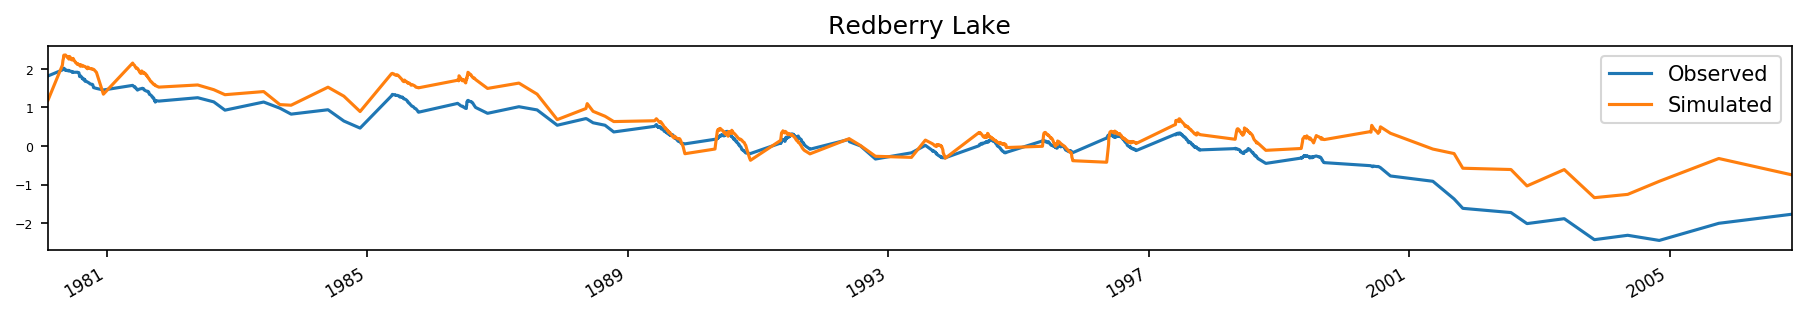

16 of 1000 (best like=-0.26306)


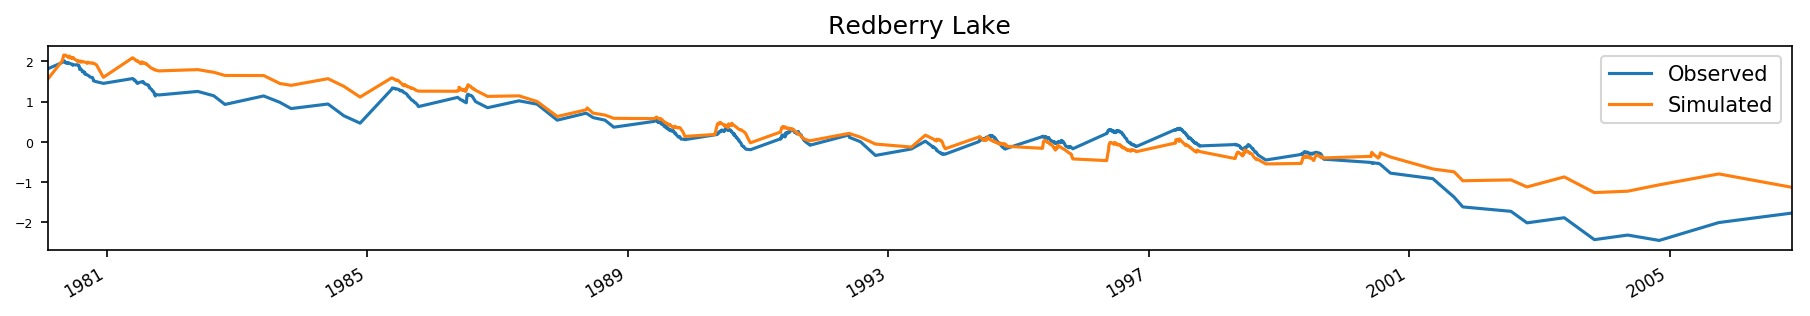

17 of 1000 (best like=-0.250634)


In [ ]:
cal_setup = spotpy_setup()

#startTime = datetime.datetime.now()
sampler = spotpy.algorithms.sceua(cal_setup,dbname='SCEUA_VIC2',dbformat='csv')

# run calibration process
sampler.sample(1000)

In [209]:
results = [] # empty list to append iteration results
results.append(sampler.getdata)

[<bound method sceua.getdata of <spotpy.algorithms.sceua.sceua object at 0x7f1df62f7d90>>]

# Best parameter set
With 100 runs
0.17757522  0.74199706  0.65996649  0.21827834  1.21053735  0.31481588

with 1000 runs
(0.19358489489, 0.365624550985, 1.0182822638, 0.187749009682, 0.948439716484, 1.53954852853)
RMSE value: -0.228061665668

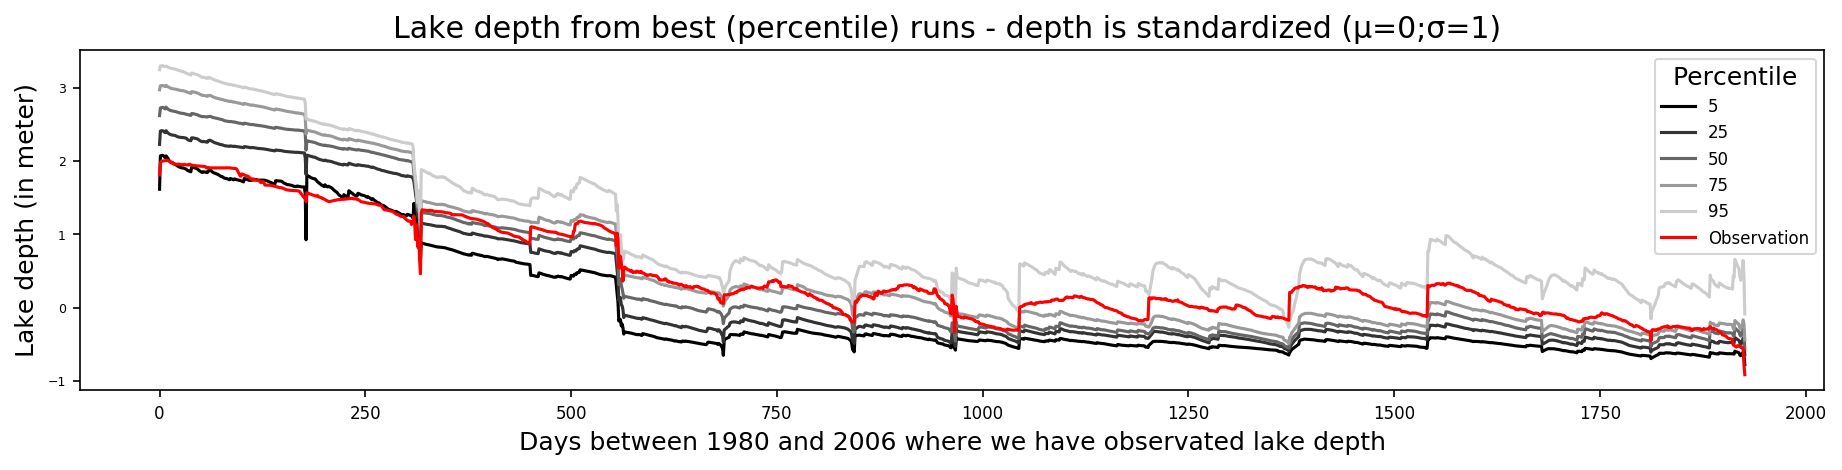

In [253]:
spotpy.analyser.get_best_parameterset(results)
pos = spotpy.analyser.get_posterior(results)
per = spotpy.analyser.get_percentiles(results)
len(per)

plt.figure(dpi=150, figsize=(15,3))
for i in range(5): plt.plot(per[i][0:-10], color=str(i/5.0))
plt.plot(evaluation[0:-10], color="r")
plt.legend("5, 25, 50, 75, 95, Observation".split(", "), title="Percentile", fontsize=8)
plt.title(u"Lake depth from best (percentile) runs - depth is standardized (μ=0;σ=1) ")
plt.ylabel(u"Lake depth (in meter)"); plt.xlabel("Days between 1980 and 2006 where we have observated lake depth")

# Parameter Trace

The figure as been saved as "binfil_Ws_DsMax_Ds_Soil_D2_Soil_D3_trace.png"


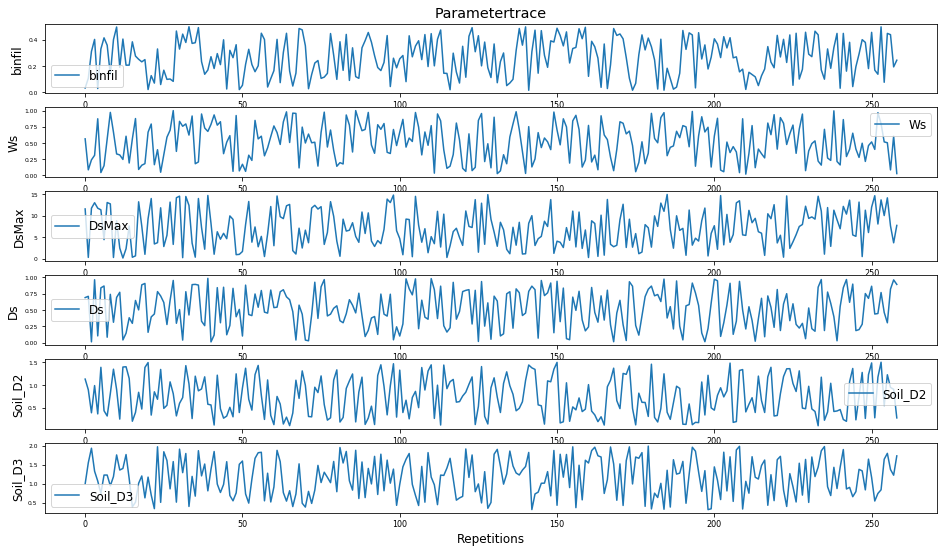

In [254]:
results = sampler.getdata()                          # Load the results
spotpy.analyser.plot_parametertrace(results)

In [213]:
spotpy.analyser.get_best_parameterset(results)

array([ (0.177575223528, 0.74199706351, 0.659966493063, 0.218278335938, 1.21053734771, 0.314815879058)], 
      dtype=[('parbinfil', '<f8'), ('parWs', '<f8'), ('parDsMax', '<f8'), ('parDs', '<f8'), ('parSoil_D2', '<f8'), ('parSoil_D3', '<f8')])

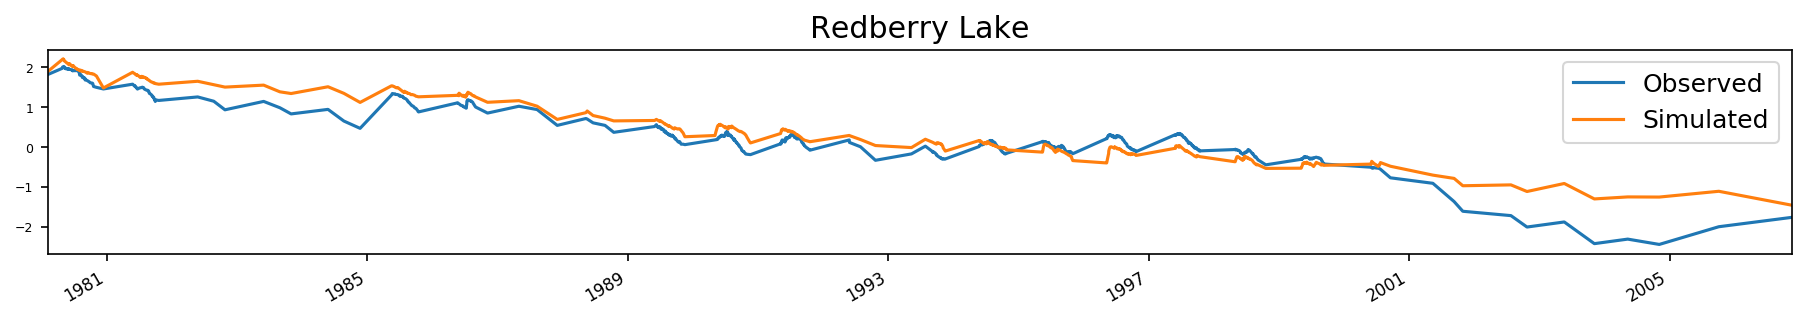

-0.21667620140616781

In [214]:
#print 
evaluation = spotpy_setup().evaluation()
simulation = spotpy_setup().simulation([0.19358489489,0.365624550985,1.0182822638,0.187749009682,0.948439716484,1.53954852853])
spotpy_setup().objectivefunction(simulation, evaluation)
#spotpy_setup().simulation()
#print results[0]().dtype.names[1:6]
#print list(results[0]()[-1])[1:6]

In [ ]:
simulation = spotpy_setup().simulation([0.37150373842200002, 0.93204422343000004, 0.040459913128700002, 0.22689123758099999, 0.546199744288])
                                       #[0.42193107,  0.6736872,   0.143702,    1.16165977,  1.62129933])
spotpy_setup().objectivefunction(simulation, evaluation)

In [ ]:
plot_same_range()
plot_lake(redberry_obs_file, redberry_sim_filename, "Redberry Observed & Simulated", 3, year=1990)

In [38]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [255]:
%matplotlib inline
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000})
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

# Best set [ 0.27499073  0.72366531  0.11720323  0.32699777  1.92498418]

def f(binfil, Ws, DsMax, Ds, d2, d3):
    simulation = spotpy_setup().simulation([binfil, Ws, DsMax, Ds, d2, d3])
    #plot_same_range()

interactive_plot = interactive(f, binfil=(0.01, 1, 0.1), Ws=(0.1, 1, 0.2), DsMax = (0.1, 10, 1), Ds = (0.01, 1, 0.2), d2=(0.01, 0.5, 0.05), d3=(0.1, 2, 0.2))
output = interactive_plot.children[-1]
output.layout.height = '350px'

print "Done!"
interactive_plot

Done!
